# 0.1 Imports

In [154]:
import pickle
import pandas  as pd
import seaborn as sns
import numpy   as np
import scikitplot as skplt

import matplotlib.pyplot         as plt


from boruta  import BorutaPy
from sklearn import linear_model as lm
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from tabulate import tabulate


from sklearn.metrics import top_k_accuracy_score
from IPython.core.display import HTML 
from IPython.display             import Image


# 0.2 Helper Functions

In [153]:
def jupyter_settings(): 
    %matplotlib inline 
    #%matplotlib notebook
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
     
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option ('display.expand_frame_repr', False)
    
    sns.set()

In [4]:
%matplotlib inline 
%matplotlib notebook

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24


display( HTML( '<style>.container { width:100% !important; }</style>') )
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option ('display.expand_frame_repr', False)

sns.set()

In [5]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 1.0 Data Description

## 1.1 Loading data

In [108]:
df1= pd.read_csv ('/Users/adriele/Documents/repos/pa004/dataset/data.csv')

### 1.1.1 Rename columns

In [109]:
# rename columns
df1.columns = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
               'driving_license', 'vehicle_age', 'vehicle_damage',
               'previously_insured', 'annual_premium', 'vintage', 'response']



## 1.2 Data Dimensions

In [110]:
print( 'Number of Cols {}'.format( df1.shape[1] ) )
print( 'Number of Rows {}'.format( df1.shape[0] ) )

Number of Cols 12
Number of Rows 131948


## 1.3 Check NA

In [111]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 Check Data Types

In [112]:
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int64
policy_sales_channel     int64
driving_license          int64
vehicle_age             object
vehicle_damage          object
previously_insured       int64
annual_premium           int64
vintage                  int64
response                 int64
dtype: object

## 1.5 Descriptive Startistical 

In [113]:
num_attributes = df1.select_dtypes ( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes ( exclude = ['int64', 'float64'] )

### 1.5.1 Numerical Atributes

In [114]:

# Central tedency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply ( np.median ) ).T

# Dispersin - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min () )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew () )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis () ) ).T

n = pd.concat([ d2, d3, d4, ct1, ct2, d1, d5, d6 ]).T.reset_index()
n.columns = [ 'atributtes', 'min', 'max', 'range', 'mean', 'median','std', 'skew', 'kurtosis' ]
n

,atributtes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,131947.0,131947.0,65973.500000,65973.5,38090.106658,0.000000,-1.200000
1,age,45.0,85.0,40.0,56.939635,55.0,9.469115,0.640036,-0.649460
2,region_code,0.0,52.0,52.0,26.985388,28.0,12.310347,-0.209233,-0.407361
3,policy_sales_channel,1.0,163.0,162.0,74.217237,30.0,53.440006,0.200884,-1.768637
4,driving_license,0.0,1.0,1.0,0.994096,1.0,0.076609,-12.899263,164.393472
5,previously_insured,0.0,1.0,1.0,0.313427,0.0,0.463886,0.804403,-1.352957
6,annual_premium,2630.0,540165.0,537535.0,32301.524040,34034.5,19160.604775,1.920845,36.133813
7,vintage,10.0,299.0,289.0,154.276010,154.0,83.644379,0.001730,-1.201913
8,response,0.0,1.0,1.0,0.159517,0.0,0.366158,1.859780,1.458803


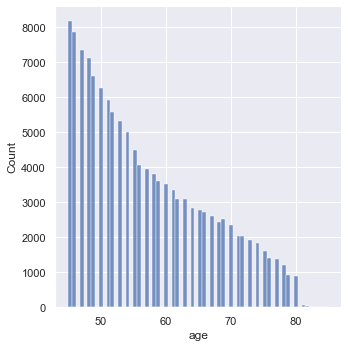

In [115]:
sns.displot( df1['age'])

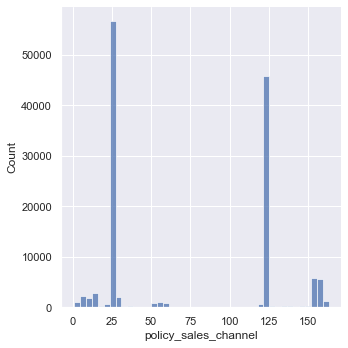

In [116]:
sns.displot( df1['policy_sales_channel'])

### 1.5.2 Attributes Category

In [117]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

<AxesSubplot:xlabel='vehicle_damage', ylabel='annual_premium'>

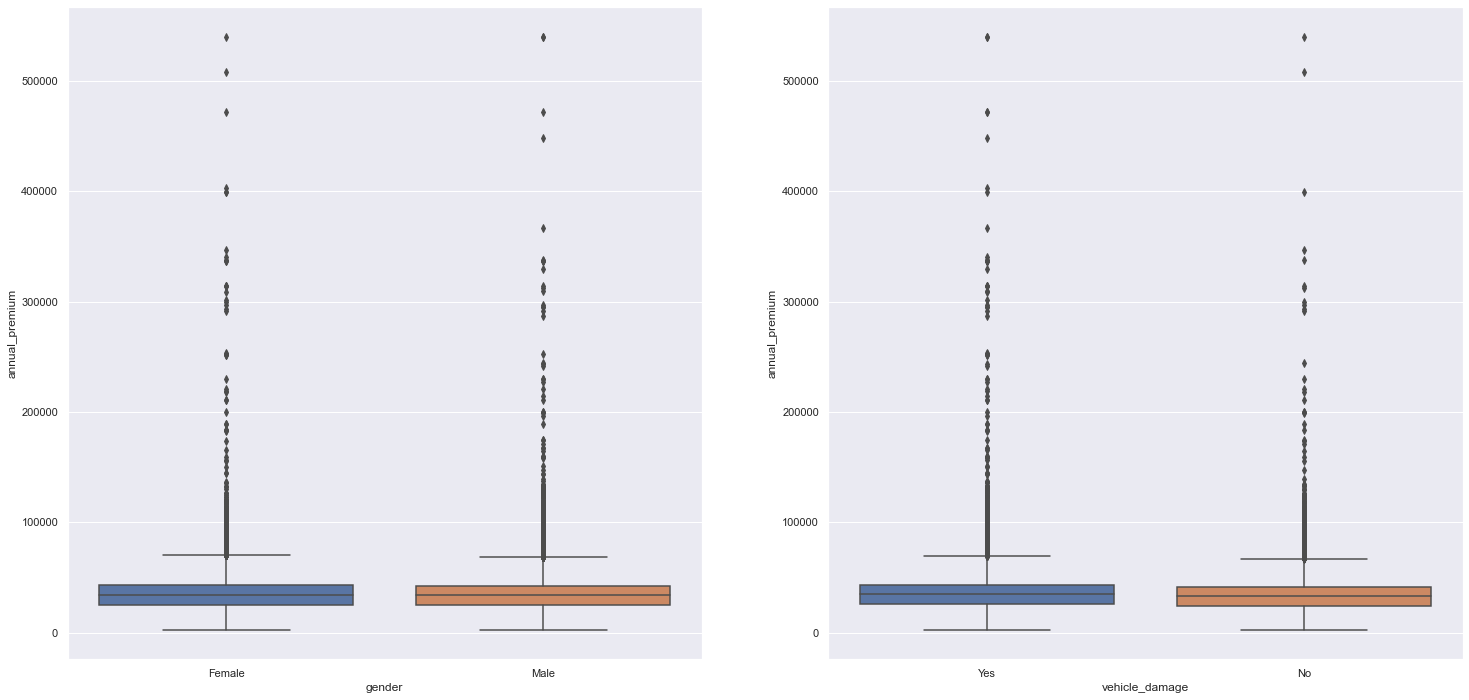

In [118]:
aux1 = df1[( df1[ 'gender' ] != '0') & (df1[ 'annual_premium' ] >0 )]

plt.subplot (1, 2, 1)
sns.boxplot (x = 'gender', y='annual_premium', data = aux1)

plt.subplot (1, 2, 2)
sns.boxplot (x = 'vehicle_damage', y='annual_premium', data = aux1)

# 2.0 Feature Engeneering - Mind Map

In [119]:
df2 = df1.copy()

# Vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' 
                                              if x == '> 2 Years' else 'between_1_2_years' 
                                              if x == '1-2 Year' else 'below_1_year')

# Vehicle demage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'yes' else 0)

## 2.1 Mind Map

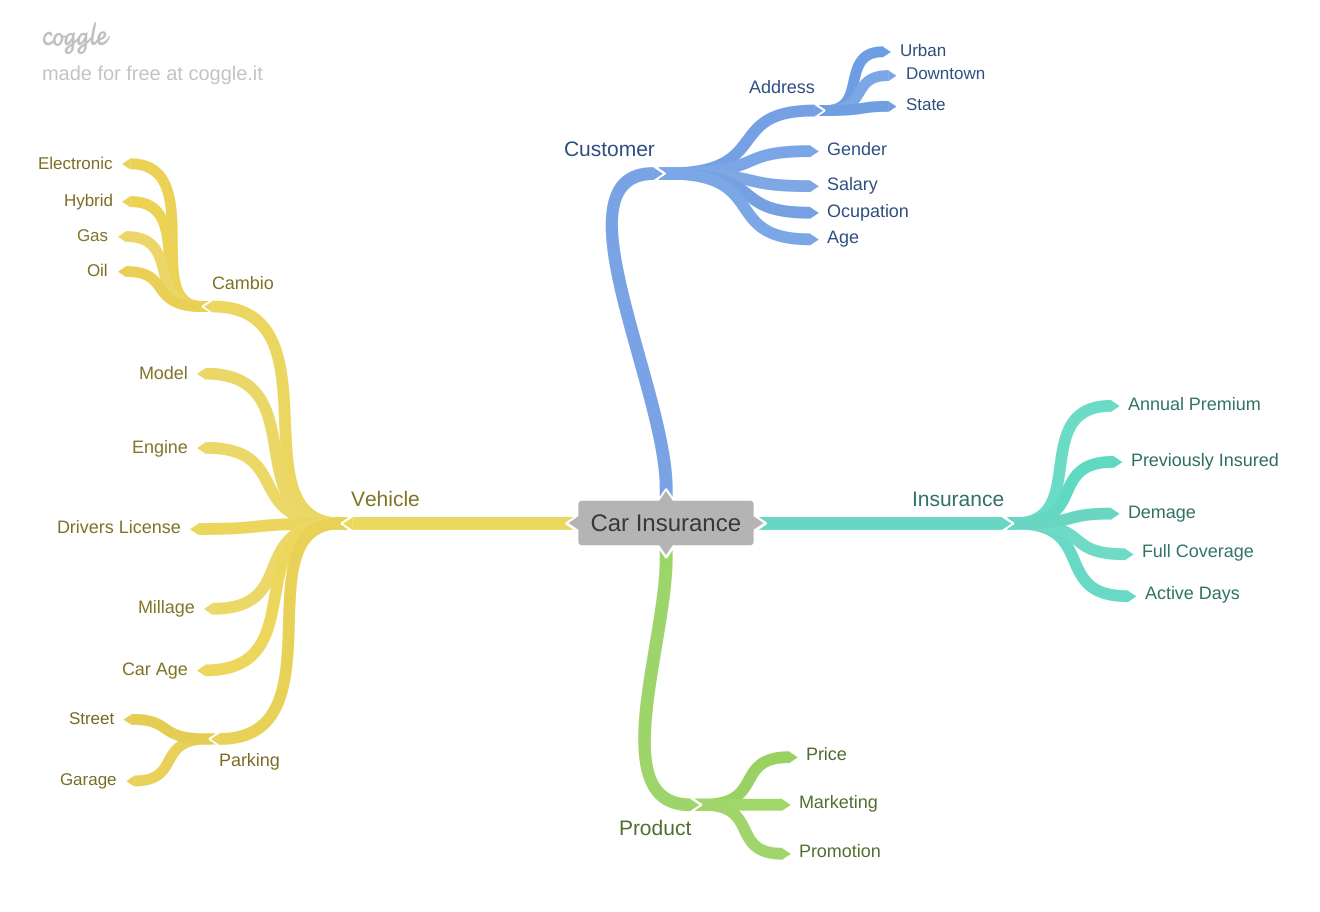

In [120]:
Image ('/Users/adriele/Documents/repos/pa004/image/mindmap.png')

## 2.2 Hypothesy List

Customer 

- 50% of female customers would be interested on the car insurance.
- Customers over 50 years old would be interested on the car insurance.
- Customers with salary up to 40k annually would be interested on the car insurance.
- 80% of Field customers wouldn't be interested on the car insurance.
- Customer outside of State wouldn't be interested on the car insurance.


Vehicle

- Customers who has cars less than one year are insterested on the car insurance.
- Customers who park doesn't have privately park are intereste on the car insurance.
- 30% of customers who has driver license would be insterested on the car insurance.
- Vehicle with new models would be insterested on the car insurance.
- 90% of car work by gas.

Insurance

- Customer with more than one damage car would be insterested on the car insurance.
- Customers that paid for annually premmiun less than 40.000 would be insterested on the car insurance.
- Customers up to 120 days of association on Health Insurance would be insterested on the car insurance.
- 80% of customers who had a previously insurance wouldn't be interested on the car insurance.



### 2.2.1  Final Hyphotesis List

- H1. 50% of female customers would be interested on the car insurance.
- H2. Customers over 50 years old would be interested on the car insurance.
- H3. 80% of Field customers wouldn't be interested on the car insurance.
- H4. Feature study - Policy Sales 
- H5. 30% of customers who has driver license would be insterested on the car insurance.
- H6. Customers who has cars less than one year are insterested on the car insurance.
- H7. H7. Feature Study - Vehicle Demage
- H8. 80% of customers who had a previously insurance wouldn't be interested on the car insurance.
- H9. Customers that paid for annually premmiun less than 40.000 would be insterested on the car insurance.
- H10. Customers up to 120 days of association on Health Insurance would be insterested on the car insurance.


# 3.0 Filtering Variables

In [121]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

In [122]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response variable

/Users/adriele/opt/anaconda3/envs/env_pa004/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='response', ylabel='Density'>

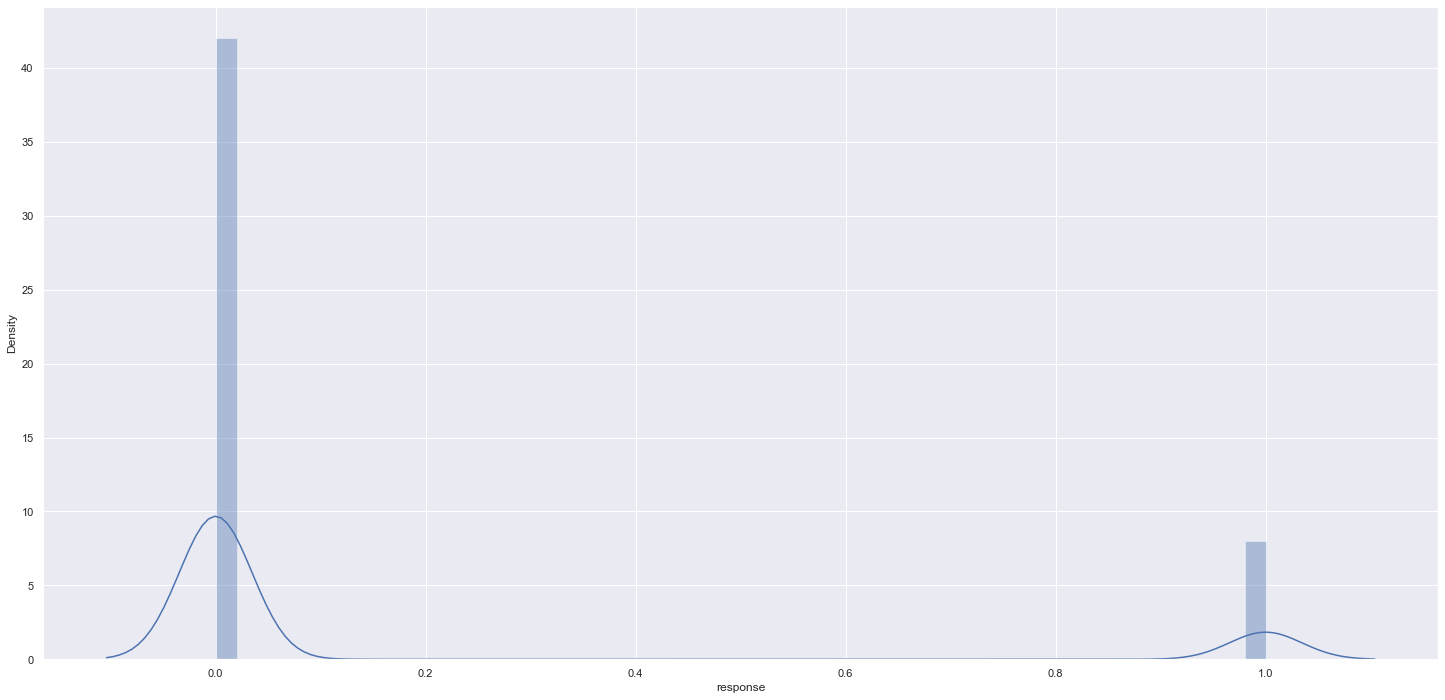

In [123]:
sns.distplot (df4['response'])

### 4.1.2 Numerical Variable

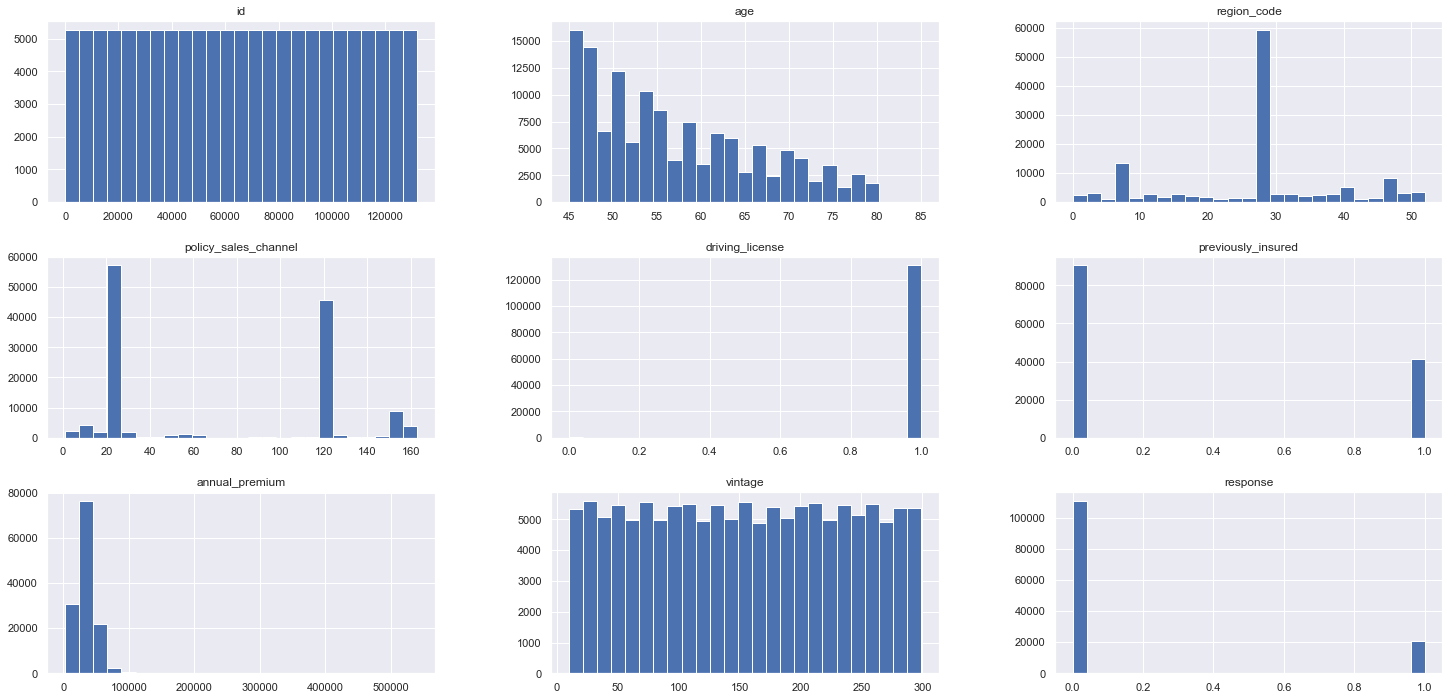

In [124]:
num_attributes.hist(bins =25);

### 4.1.3 Categorical Variable

In [125]:
cat_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

/Users/adriele/opt/anaconda3/envs/env_pa004/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

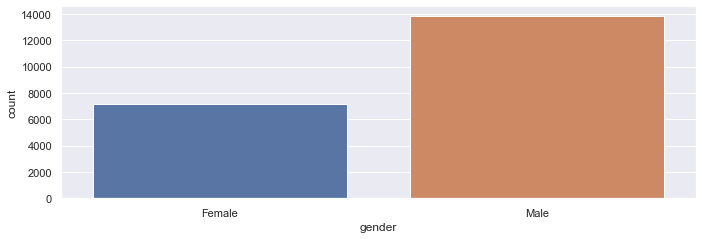

In [126]:
# Gender 
plt.subplot(3, 2, 1)
a = df4.loc[df4['response'] == 1, 'gender']
sns.countplot(a)

# plt.subplot(3, 2, 2)
# sns.kdeplot( a, label='a', shade=True)

# plt.subplot(3, 2, 3)
# sns.kdeplot(df4[df4['vehicle_damage'] == 'yes']['response'], label='a', shade=True)



## 4.2 Bivariate Analysis - Hipothesys Validatin

### <font color='orange'> 4.2.1- H1. 50% of female customers would be interested on the car insurance.
    
   <font color='green'> False - Just 5.44% are interested

/Users/adriele/opt/anaconda3/envs/env_pa004/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/adriele/opt/anaconda3/envs/env_pa004/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

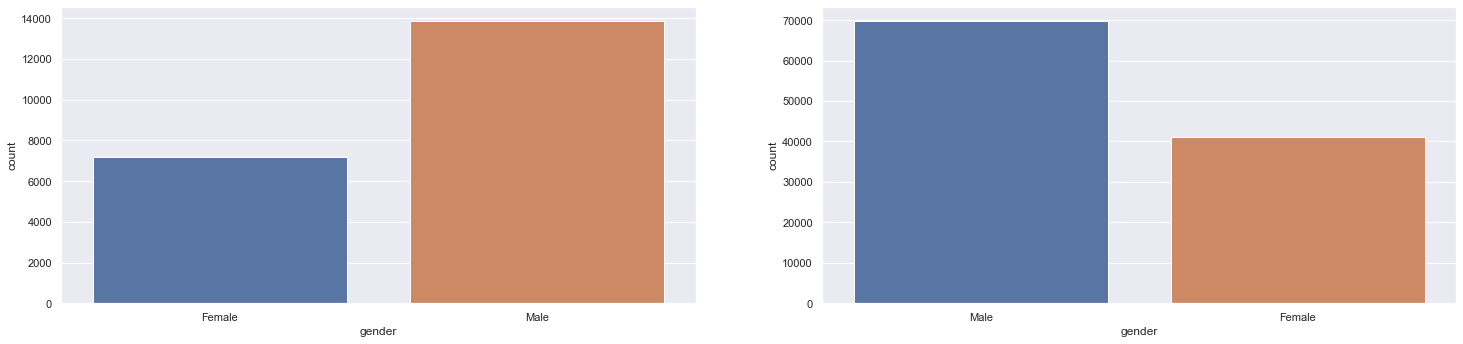

In [127]:
plt.subplot(2, 2, 1)
h0 = df4.loc[df4['response'] == 1, 'gender']
sns.countplot(h0)


plt.subplot(2, 2, 2)
h1 = df4.loc[df4['response'] == 0, 'gender']
sns.countplot(h1)




In [128]:
h6 = df4[['gender', 'response']].value_counts( normalize=True ).reset_index()
h6

,gender,response,0
0,Male,0,0.529080
1,Female,0,0.311403
2,Male,1,0.105087
3,Female,1,0.054431


- 31% Female customers are not interested.
- 5.44% Female customers interested.


- 52% Male customers are not interested.
- 10% Male customers are interested.

### <font color='orange'>  4.2.2- H2. Customers over 50 years old would be interested on the car insurance.

    
<font color='red'> False

<AxesSubplot:xlabel='age', ylabel='Count'>

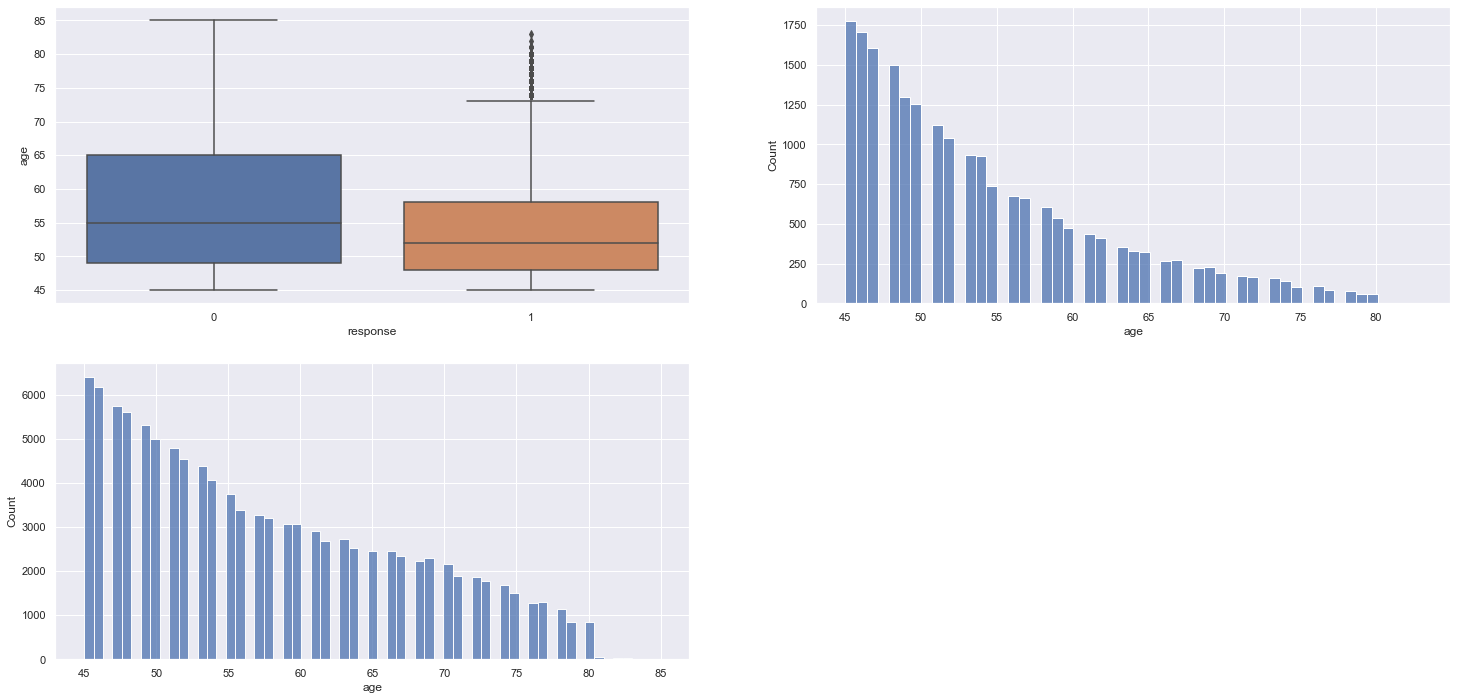

In [129]:
plt.subplot(2, 2, 1)
sns.boxplot( x='response', y='age', data=df4)

plt.subplot(2, 2, 2)
h2 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( h2 )

plt.subplot(2, 2, 3)
h2_aux = df4.loc[df4['response'] == 0, 'age']
sns.histplot( h2_aux )

- Customer over 50 years old are not interested.

### <font color='orange'>  4.2.3 - H3. 80% of Field customers wouldn't be interested on the car insurance.
<font color='blue'>    - The data are not clear to get insights.

<AxesSubplot:xlabel='region_code', ylabel='id'>

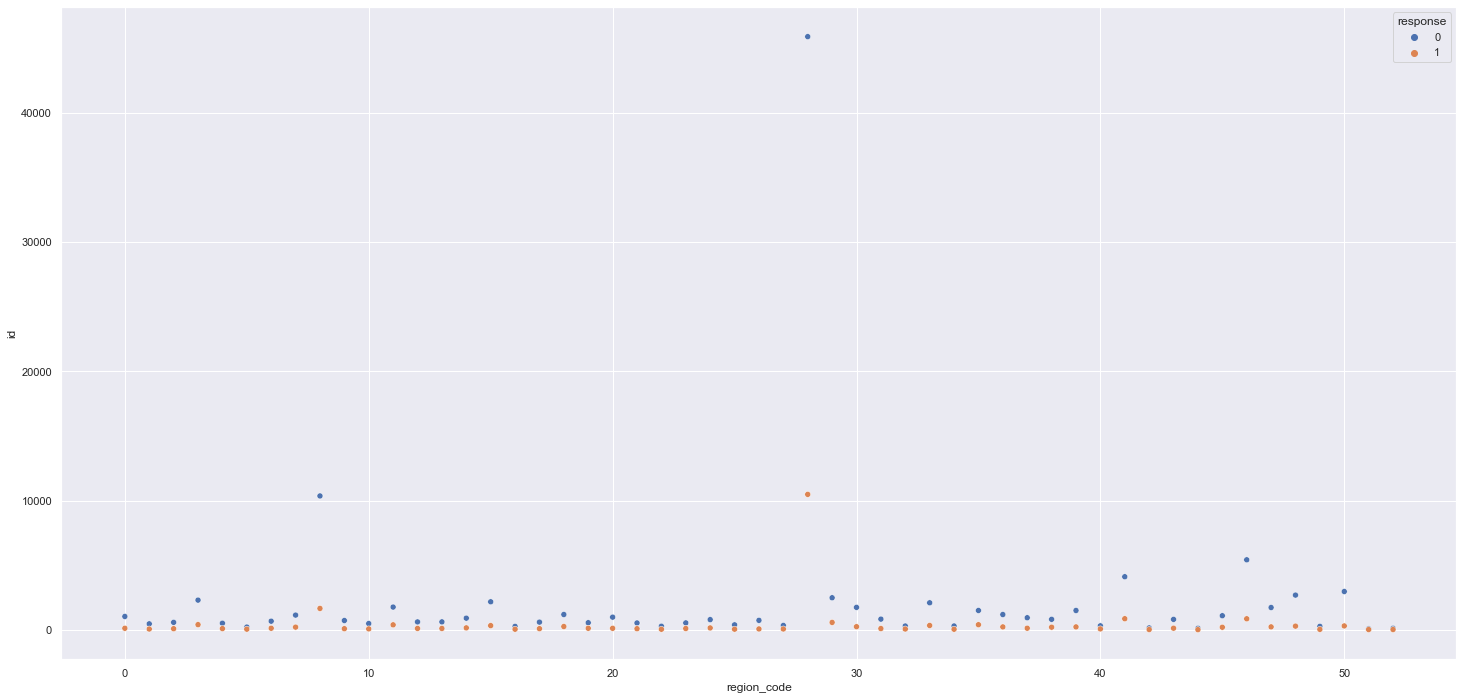

In [130]:
h3 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index() 
sns.scatterplot(x='region_code', y='id', hue='response', data=h3)

In [131]:
h3_aux = df4[['region_code', 'response']].value_counts().reset_index()
h3_aux.head()

,region_code,response,0
0,28,0,45911
1,28,1,10479
2,8,0,10358
3,46,0,5415
4,41,0,4105


- There is only one code of interested customers.

### <font color='orange'>  4.2.4- H4. Policy Sales
<font color='blue'>   The data are not clear to get insights.   

<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

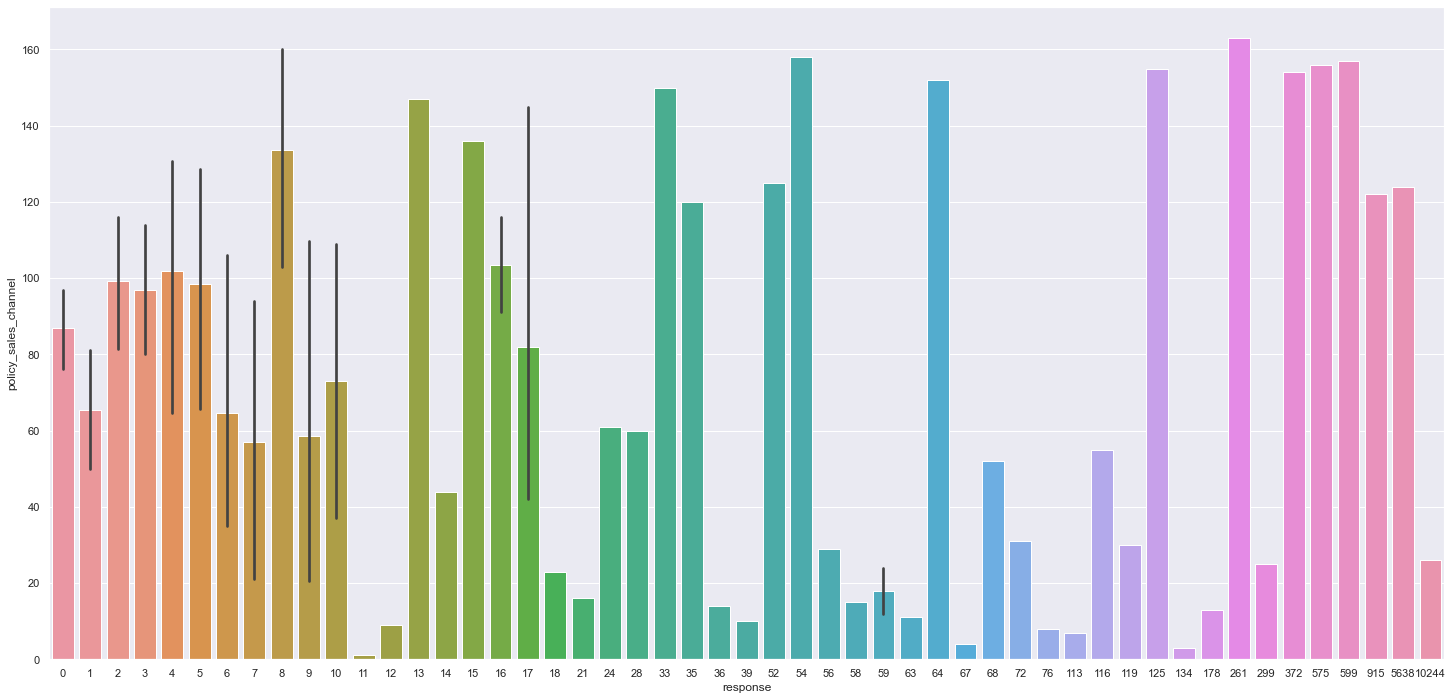

In [132]:
h4 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data= h4)

### <font color='orange'>  4.2.5 - H5. 30% of customers who has driver license would be insterested on the car insurance.
<font color='red'> False    

<AxesSubplot:xlabel='response', ylabel='driving_license'>

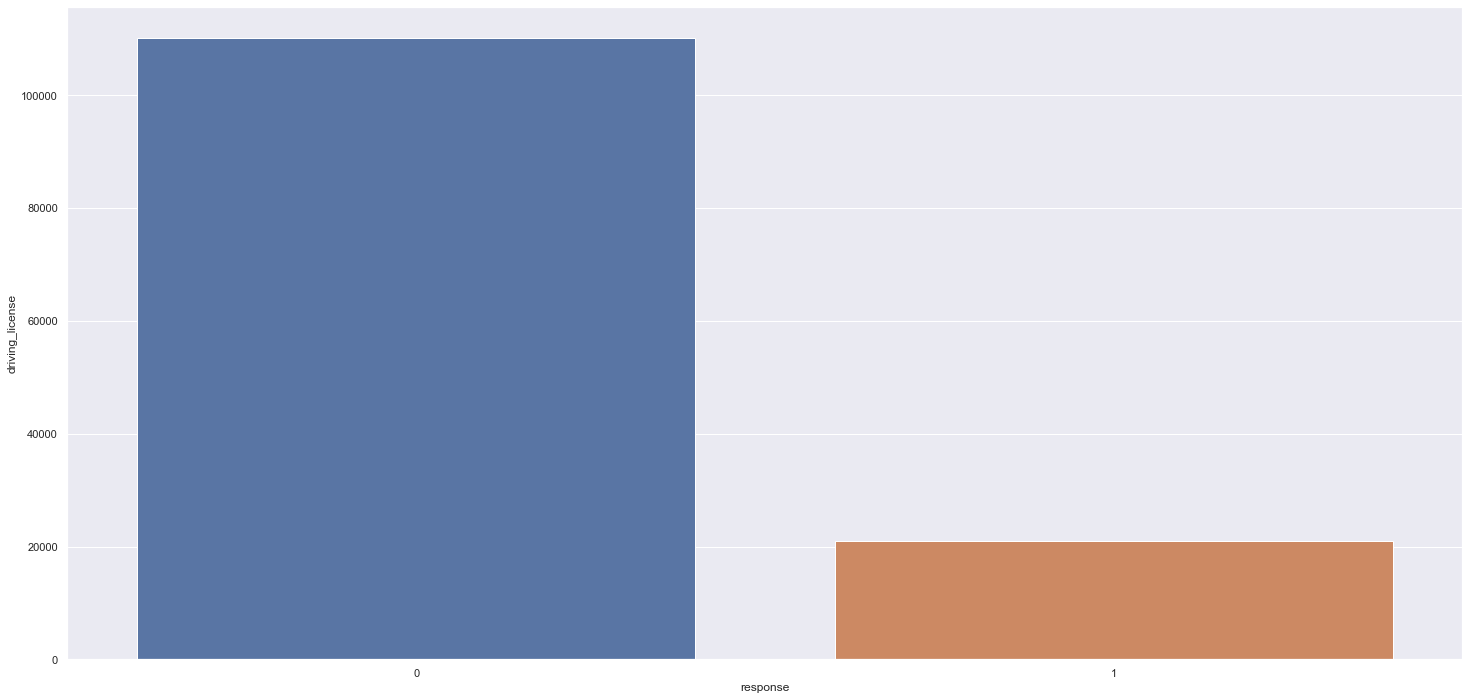

In [133]:
h5 = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot( x='response', y='driving_license', data=h5 )

In [134]:
h5.head()

,response,driving_license
0,0,110160
1,1,21009


In [135]:
h5['driving_license_perc'] = h5['driving_license'] / h5['driving_license'].sum()
h5.head()

,response,driving_license,driving_license_perc
0,0,110160,0.839833
1,1,21009,0.160167


- Only 16% of custumer who has drivers license are interested.
- Most of customers doesn't have drivers license.

### <font color='orange'>  4.2.6 - H6. Customers who has cars less than one year are insterested on the car insurance.
<font color='red'>    False

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

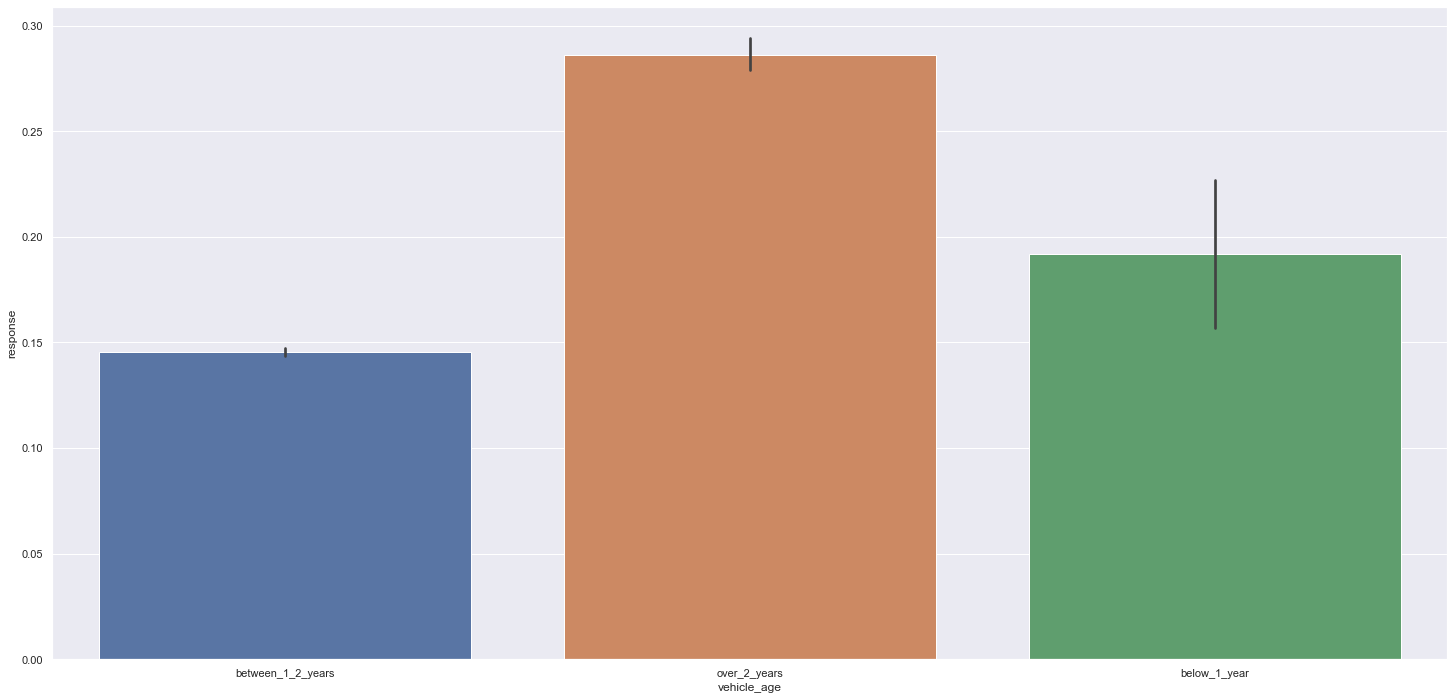

In [136]:
sns.barplot(x='vehicle_age', y='response', data=df4)

/Users/adriele/opt/anaconda3/envs/env_pa004/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

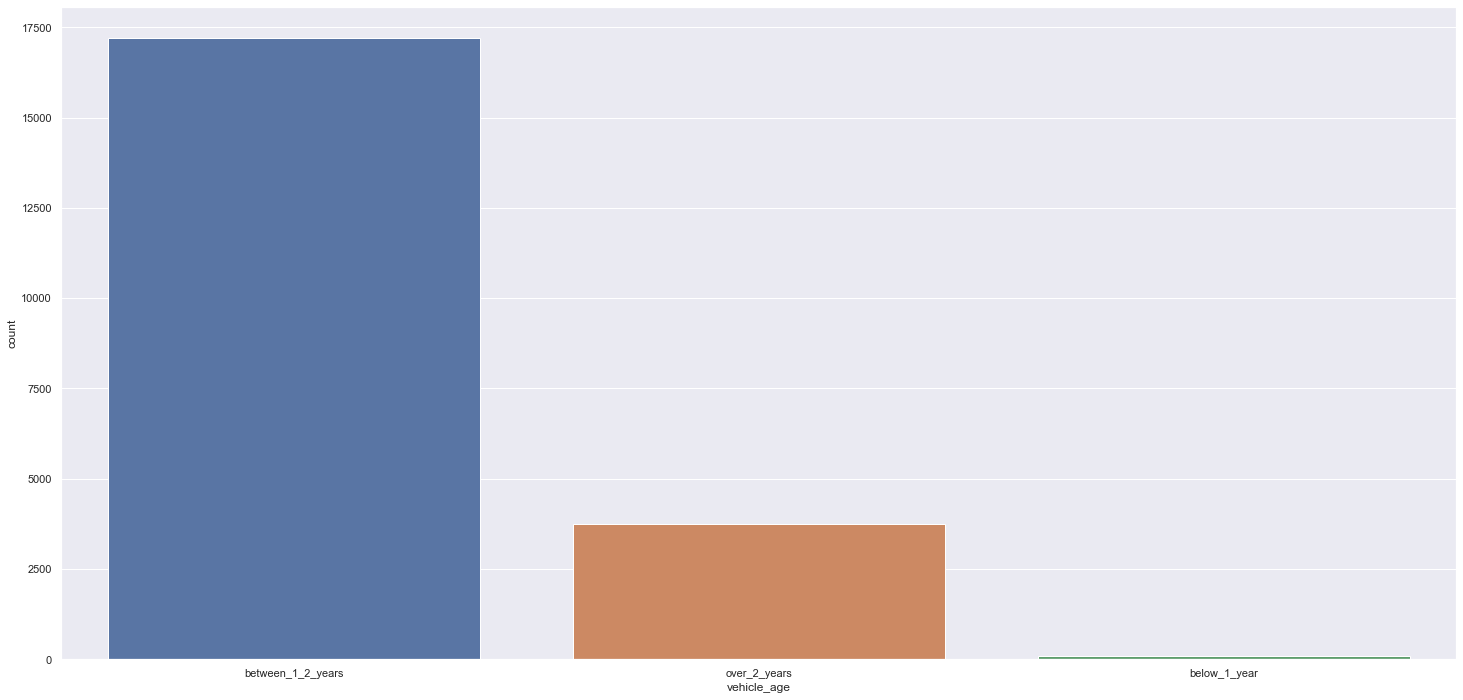

In [137]:

h = df4.loc[df4['response'] == 1, 'vehicle_age']
sns.countplot(h)

In [138]:
h6 = df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()
h6

,vehicle_age,response,0
0,between_1_2_years,0,0.766643
1,between_1_2_years,1,0.130385
2,over_2_years,0,0.070869
3,over_2_years,1,0.028428
4,below_1_year,0,0.002971
5,below_1_year,1,0.000705


- Bellow 1 year = 0.07% of customer interested.
- Between 1 and 2 yars = 13% of customer interested.
- Over years = 2.80% of customer interested.

### <font color='orange'>  4.2.7 - H7. Feature Study - Vehicle Demage
<font color='blue'>   There are no data to get insights.   

<AxesSubplot:xlabel='response', ylabel='vehicle_damage'>

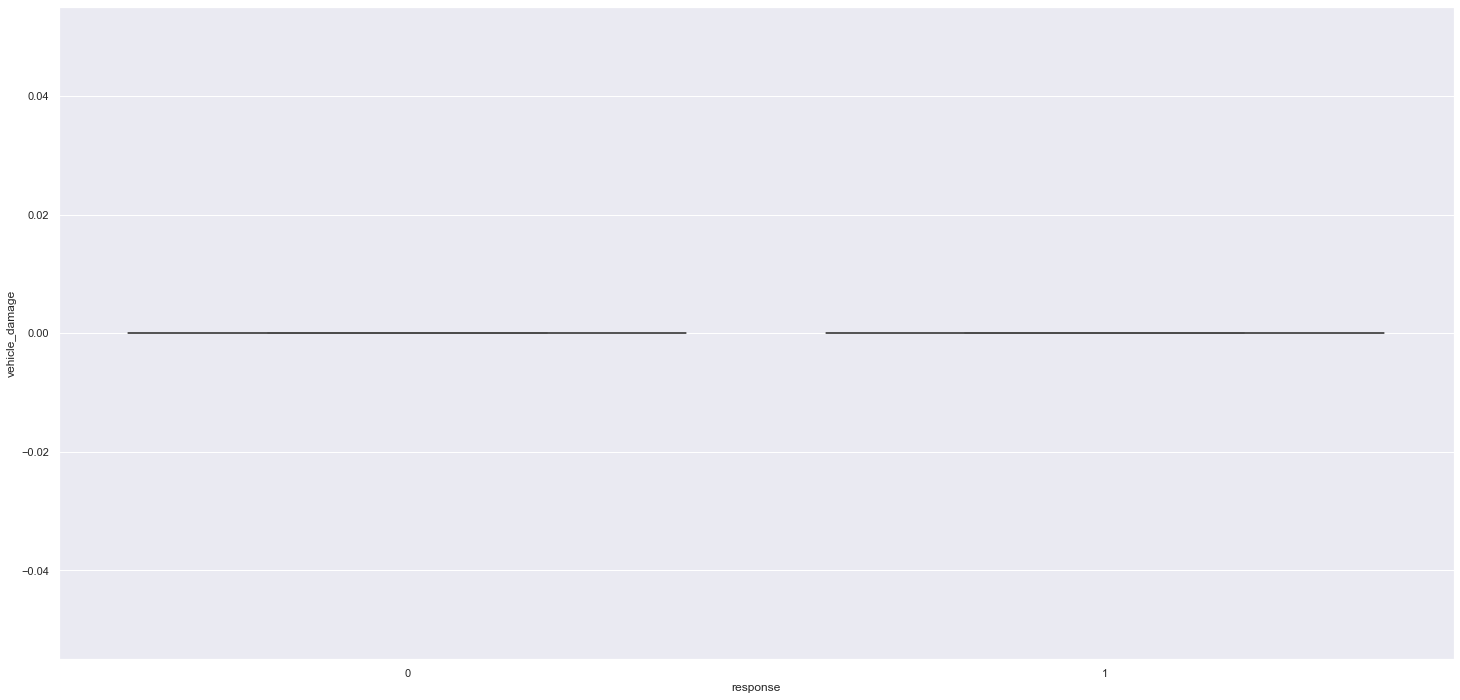

In [141]:
sns.boxplot( x='response', y='vehicle_damage', data=df4)

In [144]:
h = df4[['vehicle_damage', 'response']].value_counts( normalize=True ).reset_index()


,vehicle_damage,response,0
0,0,0,0.840483
1,0,1,0.159517


In [147]:
#h5 = df4[['vehicle_damage', 'response']].groupby('response').sum().reset_index()
#sns.barplot( x='response', y='vehicle_damage', data=h5 )

h['vehicle_damage_perc'] = h['vehicle_damage'] / h['vehicle_damage'].sum()
h.head()

,vehicle_damage,response,0,vehicle_damage_perc
0,0,0,0.840483,NaN
1,0,1,0.159517,NaN


<AxesSubplot:xlabel='vehicle_damage', ylabel='age'>

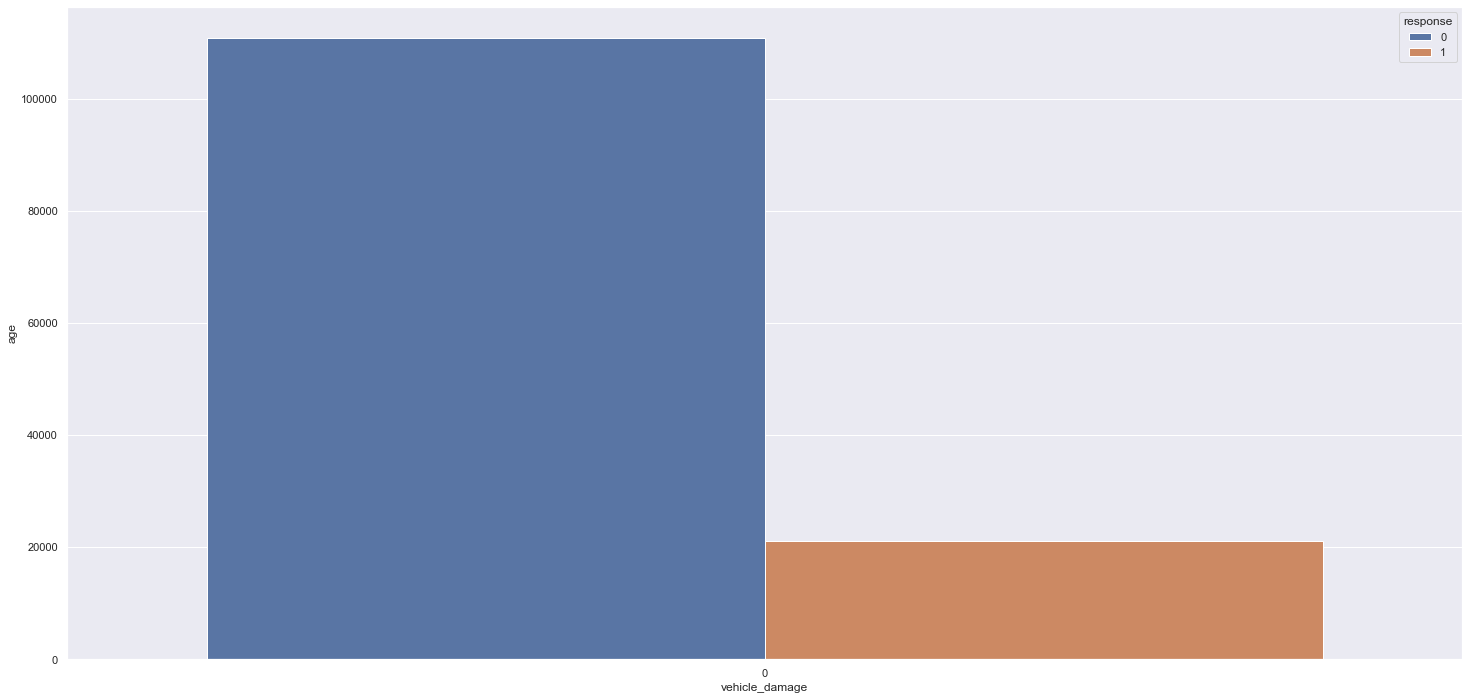

In [149]:
h = df4[['age', 'vehicle_damage', 'response']].groupby( ['vehicle_damage', 'response'] ).count().reset_index() 
sns.barplot(x='vehicle_damage', y='age', hue='response', data=h)

### <font color='orange'>  4.2.8 - H8. 80% of customers who had a previously insurance wouldn't be interested on the car insurance.
<font color='blue'>    True - More than 80% are not interested.

In [31]:
h8 = pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1)
h8.head()

response,0,1
previously_insured,,
0,0.768037,0.231963
1,0.999178,0.000822


- Only 0.23% of Customers who had a previously Insurance are interested.
- Only 0.00082% of Customers didn't have a previously Insurance are interested.

<AxesSubplot:xlabel='response', ylabel='previously_insured'>

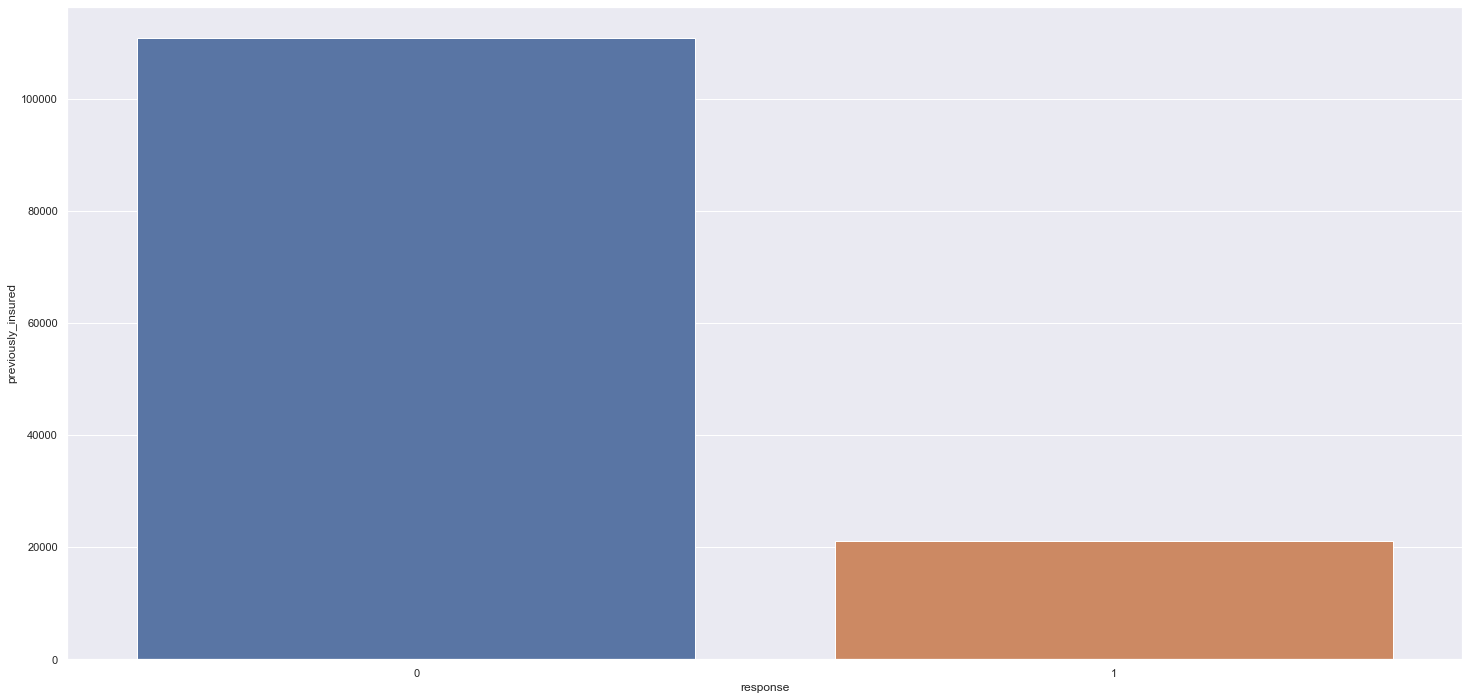

In [56]:
sns.barplot(x='response', y='previously_insured', data=df4)

### <font color='orange'>  4.2.9 - H9. Customers that paid for annually premmiun less than 40.000 would be insterested on the car insurance.
    
<font color='green'> True

In [41]:
df3['annual_premium'].max()


540165

In [42]:
df3['annual_premium'].min()

2630

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

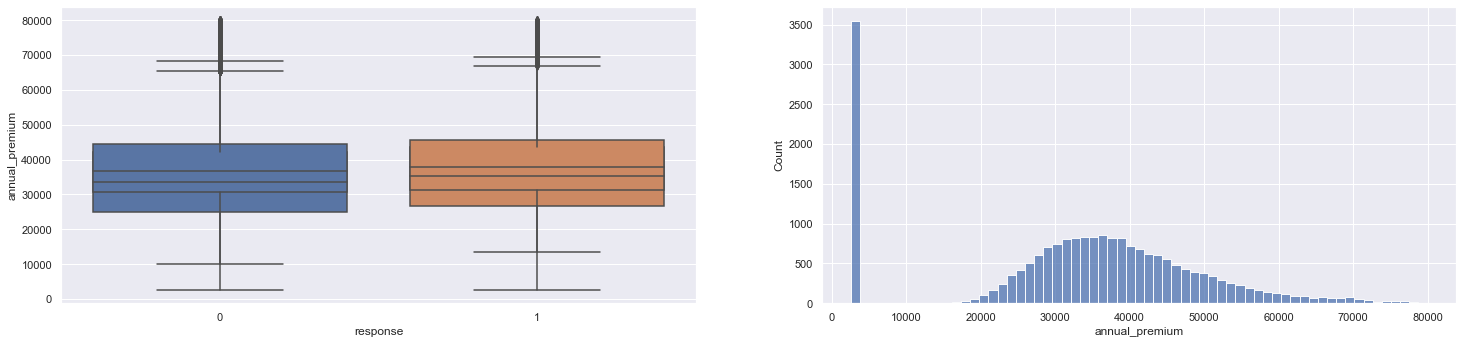

In [43]:

plt.subplot(2, 2, 1)
h9 = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=h9 )

plt.subplot(2, 2, 2)
h9_aux = h9.loc[h9['response'] == 1, 'annual_premium' ]
sns.histplot(h9_aux )

plt.subplot(2, 2, 1)
h9 = df4[(df4['annual_premium'] > 2630) & (df4['annual_premium'] < 80000)]
sns.boxplot( x='response', y='annual_premium', data=h9 )

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

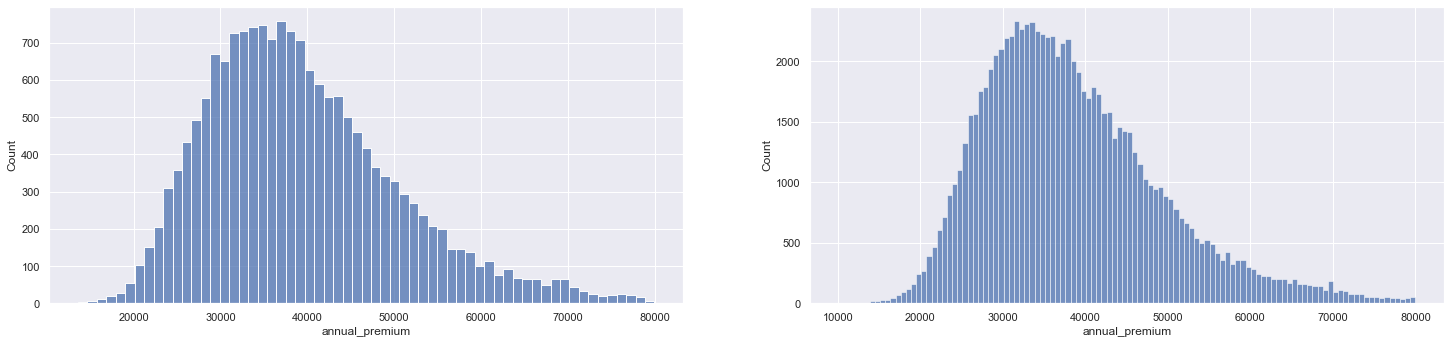

In [44]:
plt.subplot(2, 2, 1)
h9_aux1 = df4[(df4['annual_premium'] > 2630) & (df4['annual_premium'] < 80000)]
h9_aux2 = h9_aux1.loc[h9['response'] == 1, 'annual_premium' ]                                                                                          
sns.histplot( h9_aux2 )

plt.subplot(2, 2, 2)
h9_aux1 = df4[(df4['annual_premium'] > 2630) & (df4['annual_premium'] < 80000)]
h9_aux2 = h9_aux1.loc[h9['response'] == 0, 'annual_premium' ]                                                                                          
sns.histplot( h9_aux2 )

- The most interested Customere are who paid between 30,000 and 40,000.

### <font color='orange'>  4.2.10 - H10. Customers up to 120 days of association on Health Insurance would be insterested on the car insurance.
<font color='blue'> Not possible to valide the Hypothesis.  

<AxesSubplot:xlabel='vintage', ylabel='Count'>

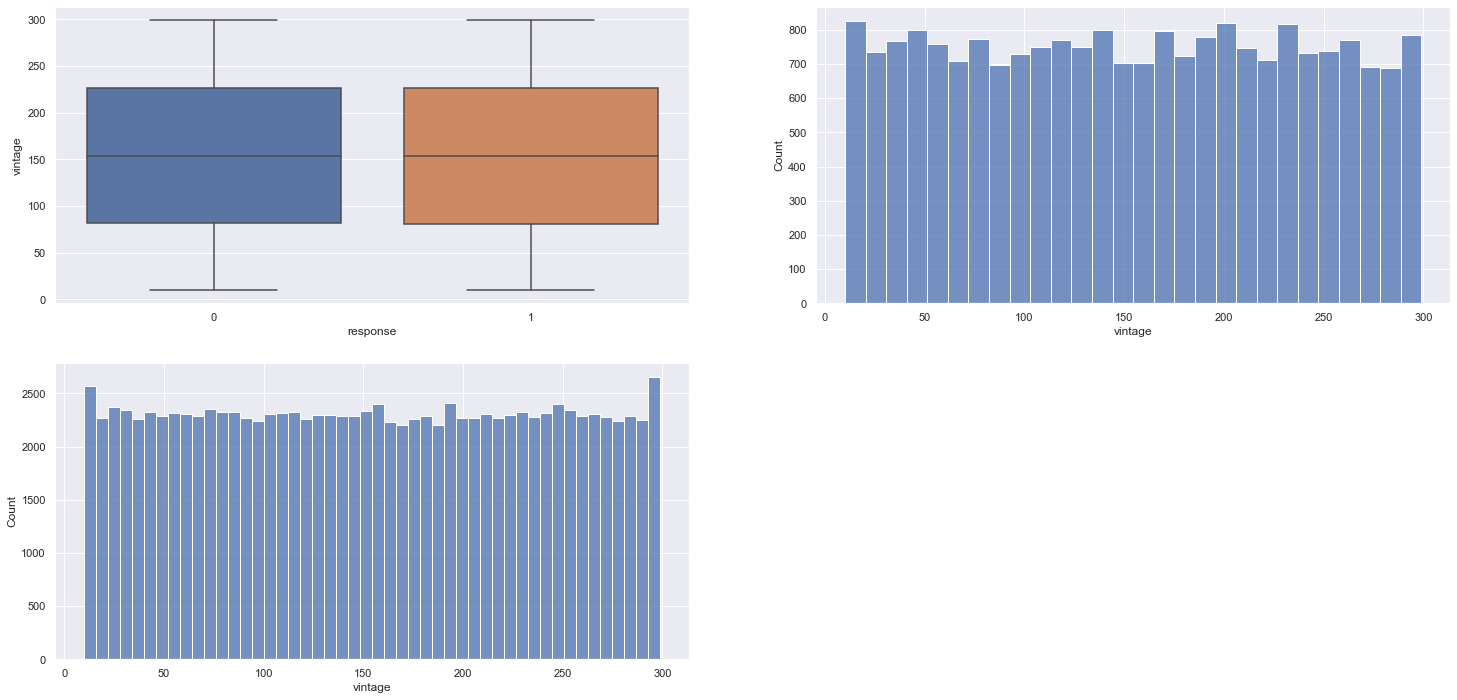

In [45]:
plt.subplot(2, 2, 1)
sns.boxplot( x='response', y='vintage', data=df4)

plt.subplot(2, 2, 2)
h10 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( h10 )

plt.subplot(2, 2, 3)
h10 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( h10 )

- The number of customers who would buy the insurance is shown to be the same as those who wouldn't buy it either.

## 4.3 Hypothesis Resume


In [155]:
tab = [[ 'Hipothesys', 'Conclusion'],
       [ 'H1', 'False'],
       [ 'H2', 'False'],
       [ 'H3', '-', '-'],
       [ 'H4', '-', '-'],
       [ 'H5', 'False'],
       [ 'H6', 'False'], 
       [ 'H7', '-', '-'],
       [ 'H8', '-', '-'],
       [ 'H9', 'True'],
       [ 'H10', '-', '-']
      ]

print (tabulate (tab, headers = 'firstrow'))

Hipothesys    Conclusion
------------  ------------
H1            False
H2            False
H3            -
H4            -
H5            False
H6            False
H7            -
H8            -
H9            True
H10           -


## 4.4 Multivariate Analysis

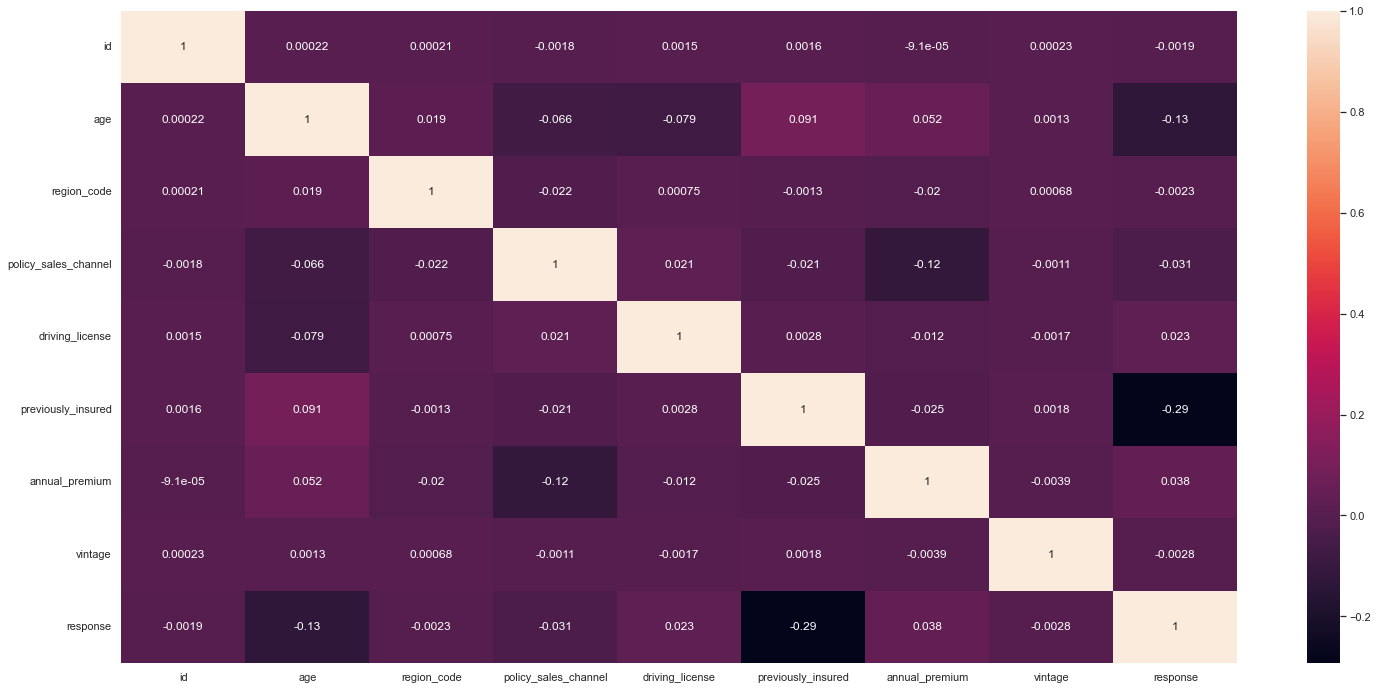

In [150]:
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap (correlation, annot = True);

# 5.0 Data Preparation

In [280]:
df5 = df4.copy()

In [281]:
x = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( x, y, test_size=0.20 )
df5 = pd.concat( [x_train, y_train], axis=1 )

In [282]:
x_validation.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage
16442,16442,Male,47,28,124,1,betwenn_1_2_years,0,1,23394,288
63343,63343,Female,68,28,26,1,betwenn_1_2_years,0,0,29842,267
92927,92927,Male,61,16,124,1,betwenn_1_2_years,0,1,2630,221
80825,80825,Female,80,20,124,1,over_2_years,0,0,2630,228
117948,117948,Male,69,28,26,1,betwenn_1_2_years,0,1,58029,110


## 5.1 Standarlization

In [150]:
ss = pp.StandardScaler()

# Annual Premium
df5['annual_premium'] = ss.fit_transform( df5[[ 'annual_premium']].values)
pickle.dump (ss, open( '/Users/adriele/Documents/repos/pa004/features/annual_premium_scaler.pkl', 'wb') )


## 5.2 Rescaling

In [151]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump (mms_age, open( '/Users/adriele/Documents/repos/pa004/features/age_scaler.pkl', 'wb') )

# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values)
pickle.dump (mms_vintage, open( '/Users/adriele/Documents/repos/pa004/features/vintage_scaler.pkl', 'wb') )

## 5.3 Encolding

In [152]:
# Region Code
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open( '/Users/adriele/Documents/repos/pa004/features/target_encode_region_code_scaler.pkl', 'wb') )

# gender
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open( '/Users/adriele/Documents/repos/pa004/features/target_encode_gender_scaler.pkl', 'wb') )

# vehicle_age
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( '/Users/adriele/Documents/repos/pa004/features/fe_policy_sales_channel_scaler.pkl', 'wb') )

## 5.4 Validation Preparation

In [153]:
#gender
x_validation.loc[:, 'gender'] = x_validation['gender'].map( target_encode_region_gender )

# region code
x_validation.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# Annual Premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[[ 'annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# Vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values)

# fill NA
x_validation = x_validation.fillna( 0 )


In [276]:
x_validation.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_below_1_year,vehicle_age_betwenn_1_2_years,vehicle_age_over_2_years,response
79373,79373,0.149509,0.45,0.0,0.414436,1,0,0,3.087727,0.297578,0,1,0,0
113365,113365,0.165560,0.00,0.0,0.414436,1,0,0,0.227484,0.332180,0,1,0,0
106026,106026,0.149509,0.70,0.0,0.414436,1,0,1,-0.082790,0.757785,0,1,0,0
101321,101321,0.149509,0.05,0.0,0.293270,1,0,1,0.460713,0.515571,0,1,0,0
20816,20816,0.149509,0.45,0.0,0.414436,1,0,1,-1.551931,0.155709,0,1,0,0


# 6.0 Feature Selection

In [154]:
df6 = df5.copy()

## 6.1 Boruta

In [155]:
# # training and test dataset for boruta
# x_train_n = df6.drop (['id', 'response'], axis=1).values
# y_train_n = y_train.values.ravel ()

# # model definition
# et = en.ExtraTreesClassifier(n_jobs=-1)
# # Defining boruta
# boruta = BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit (x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	10
I

In [157]:
cols_selected = boruta.support_.tolist()

# Best features
x_train_fs = df6.drop (['id', 'response'], axis=1)
cols_selected_boruta = x_train_fs.iloc [:, cols_selected].columns.to_list()

# Not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

In [160]:
cols_selected

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

## 6.2 Feature Definition

In [54]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                         feature  importance
0                        vintage    0.311560
0                 annual_premium    0.282337
0                            age    0.145157
0                    region_code    0.110011
0             previously_insured    0.079467
0           policy_sales_channel    0.054160
0                         gender    0.005837
0       vehicle_age_over_2_years    0.005202
0  vehicle_age_betwenn_1_2_years    0.004766
0                driving_license    0.000900
0       vehicle_age_below_1_year    0.000603
0                 vehicle_damage    0.000000


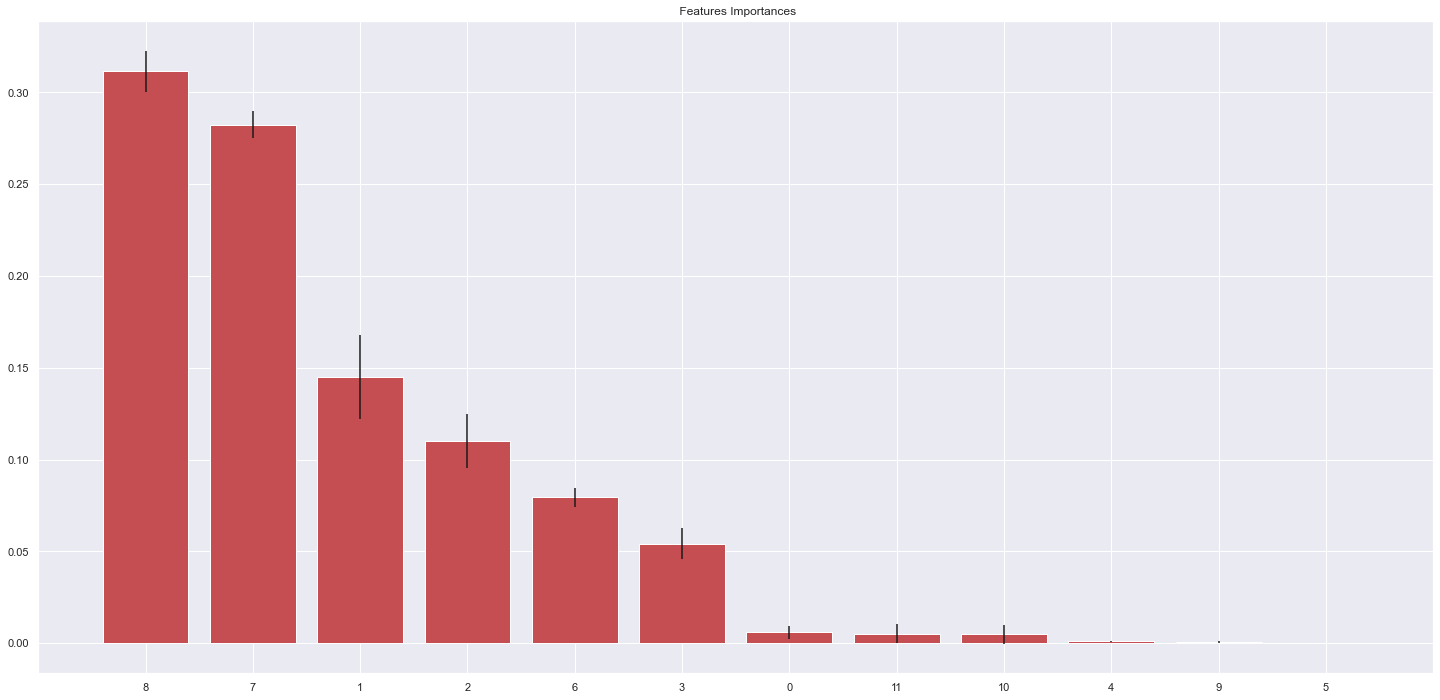

In [55]:
importances = forest.feature_importances_
std         = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices     = np.argsort(importances) [::-1]

# Print Features Rankings
print( 'Feature Ranking:')
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance' : j}, index=[0])
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )   


# Plot the impurity based importances of the forest
plt.figure()
plt.title(" Features Importances")
plt.bar( range( x_train_n.shape[1] ), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks( range( x_train_n.shape[1] ), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()    

# 7.0 Machine Learning

In [56]:
#cols_selected = ['vintage','annual_premium', 'age', 'region_code', 'previously_insured', 'policy_sales_channel', 'gender'] 

cols_selected = ['vintage','annual_premium', 'age', 'region_code','vehicle_damage',
                 'previously_insured', 'policy_sales_channel', 'gender'] 

x_train = df5[ cols_selected ]
x_val = x_validation[ cols_selected]
y_val = y_validation


## 7.1 KNN

In [82]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - the power of model; generalization
yhat_knn = knn_model.predict_proba( x_val)



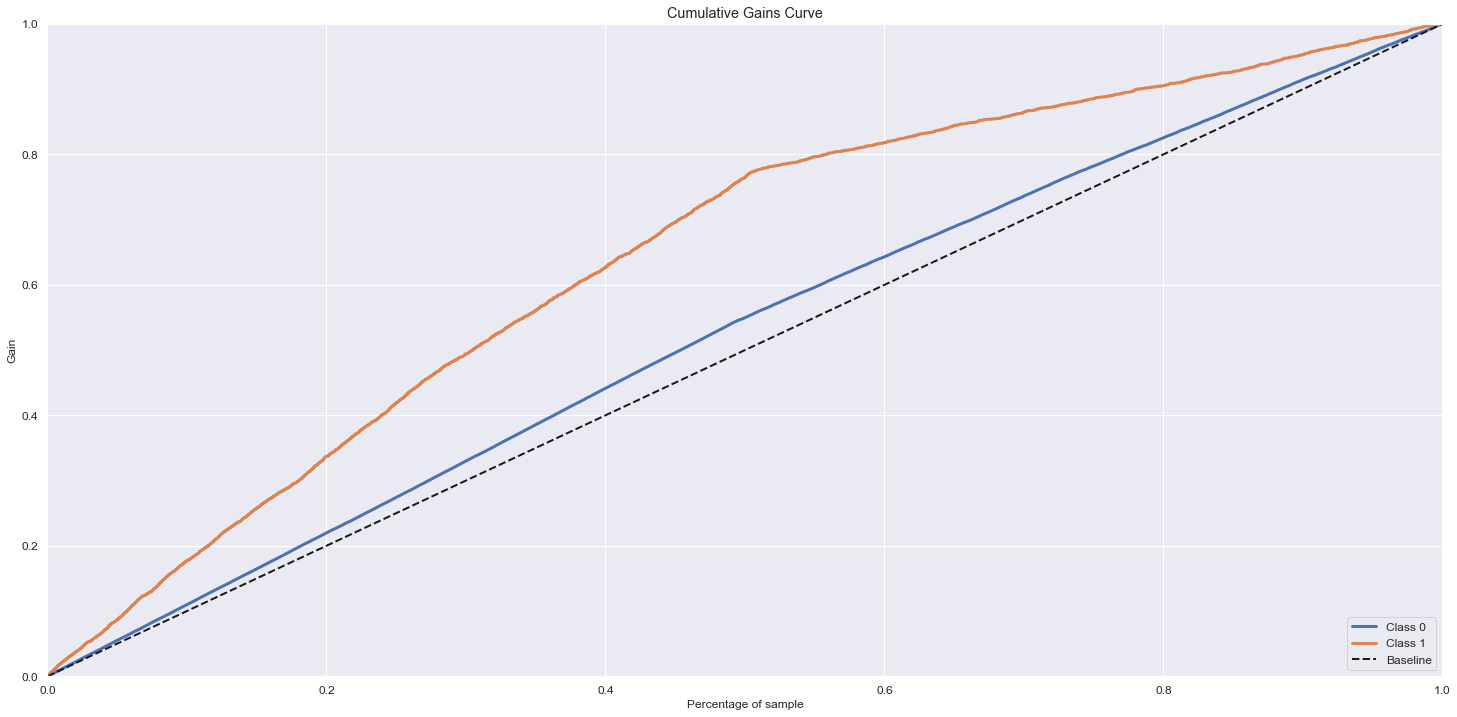

In [81]:
# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

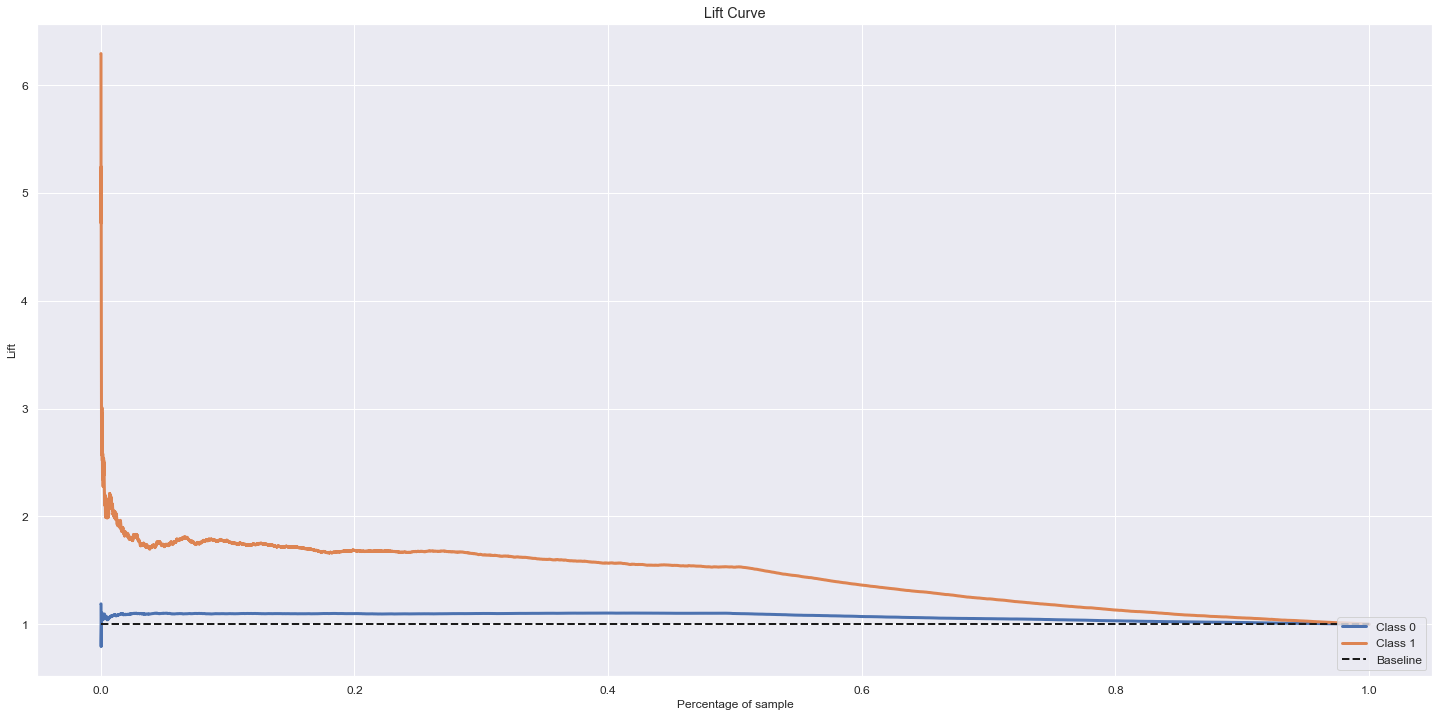

In [73]:
# Acumulative Gain
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

## 7.2 Regression Logistic

In [86]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train, y_train )

# model prediction - the power of model; generalization
yhat_lr = lr_model.predict_proba( x_val)



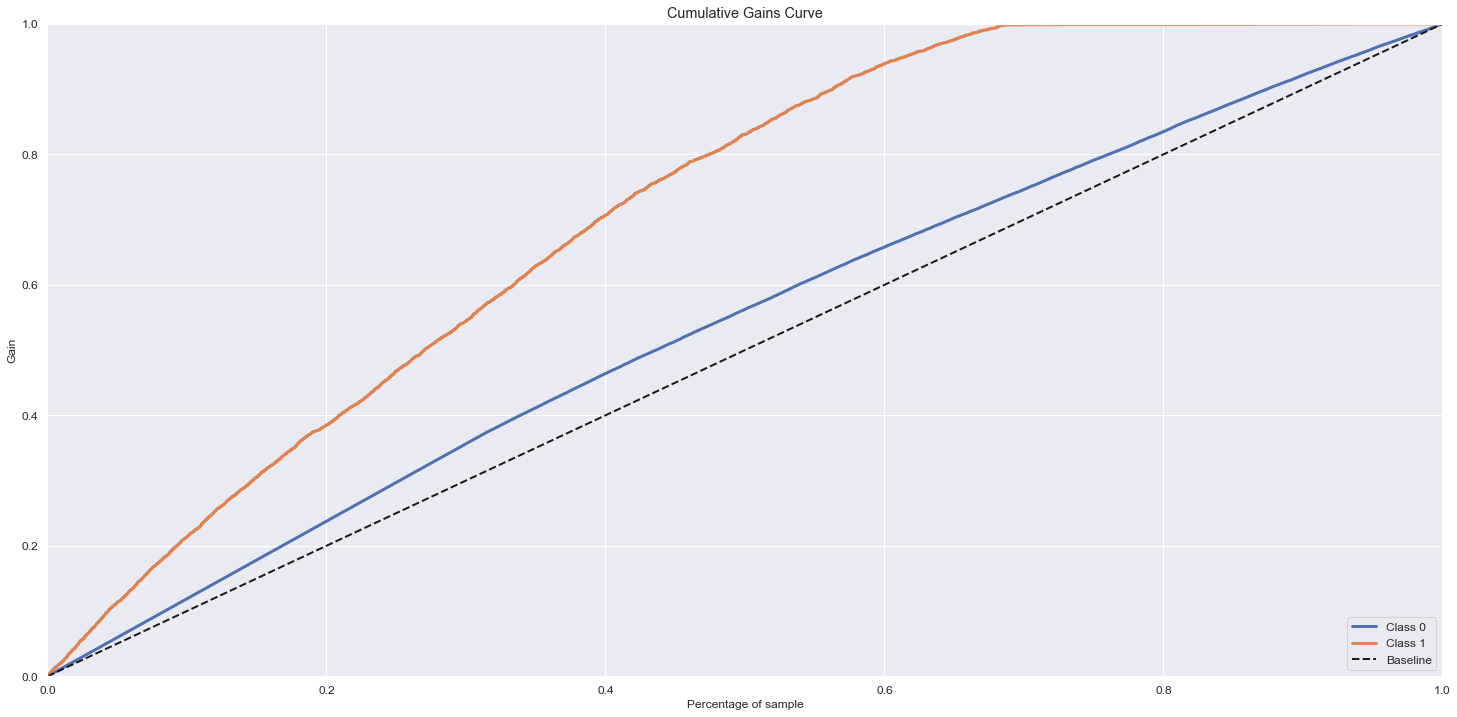

In [87]:
# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

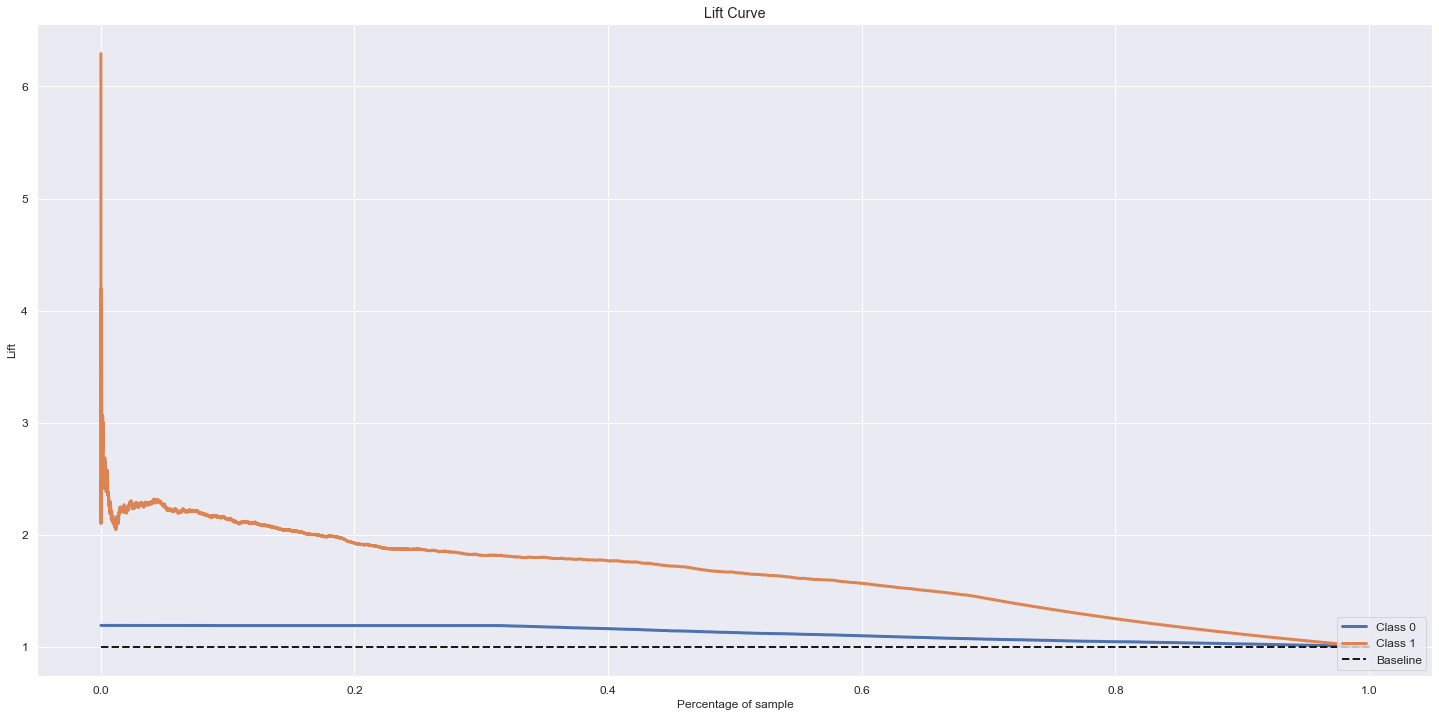

In [88]:
# Acumulative Gain
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 7.3 Extra Trees

In [78]:
# Model Definition
et= en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
et.fit(x_train, y_train)

# model predict
yhat_et = et.predict_proba( x_val )



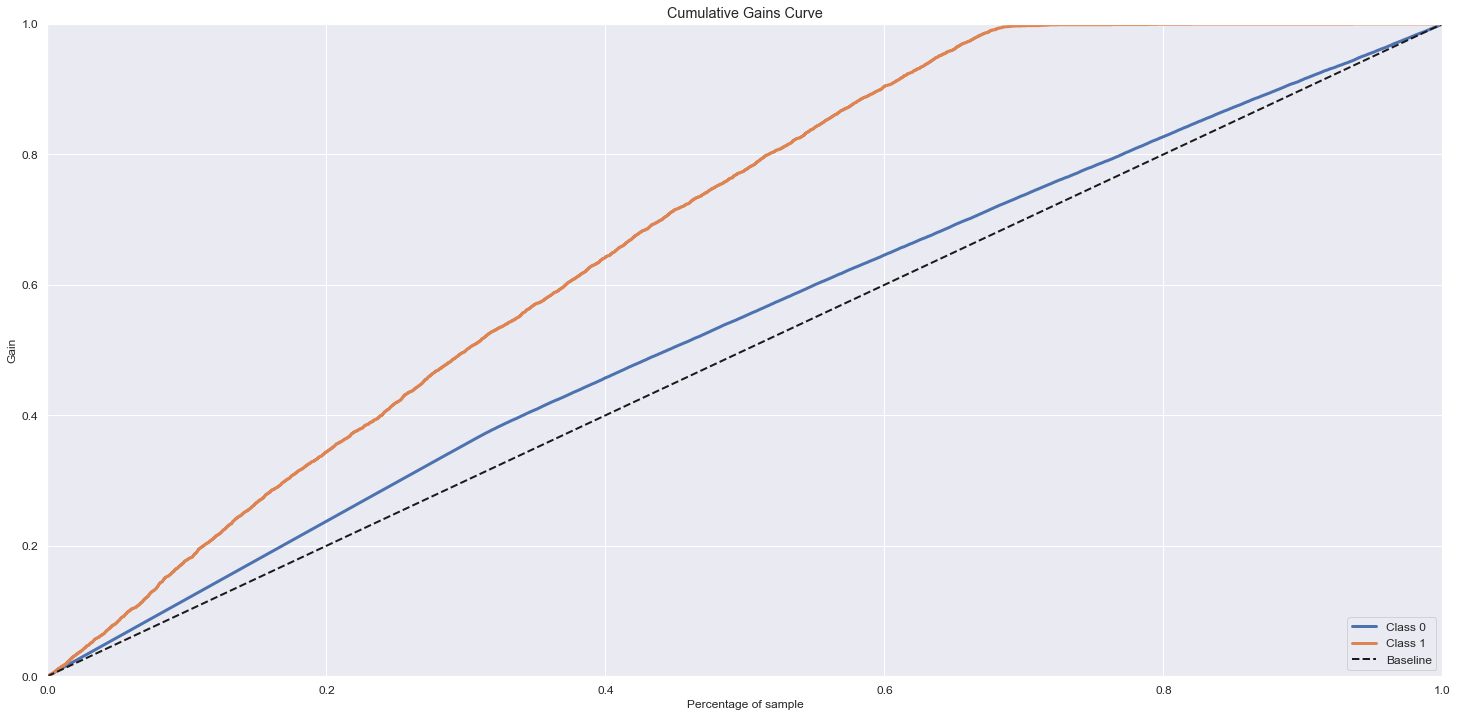

In [79]:
# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

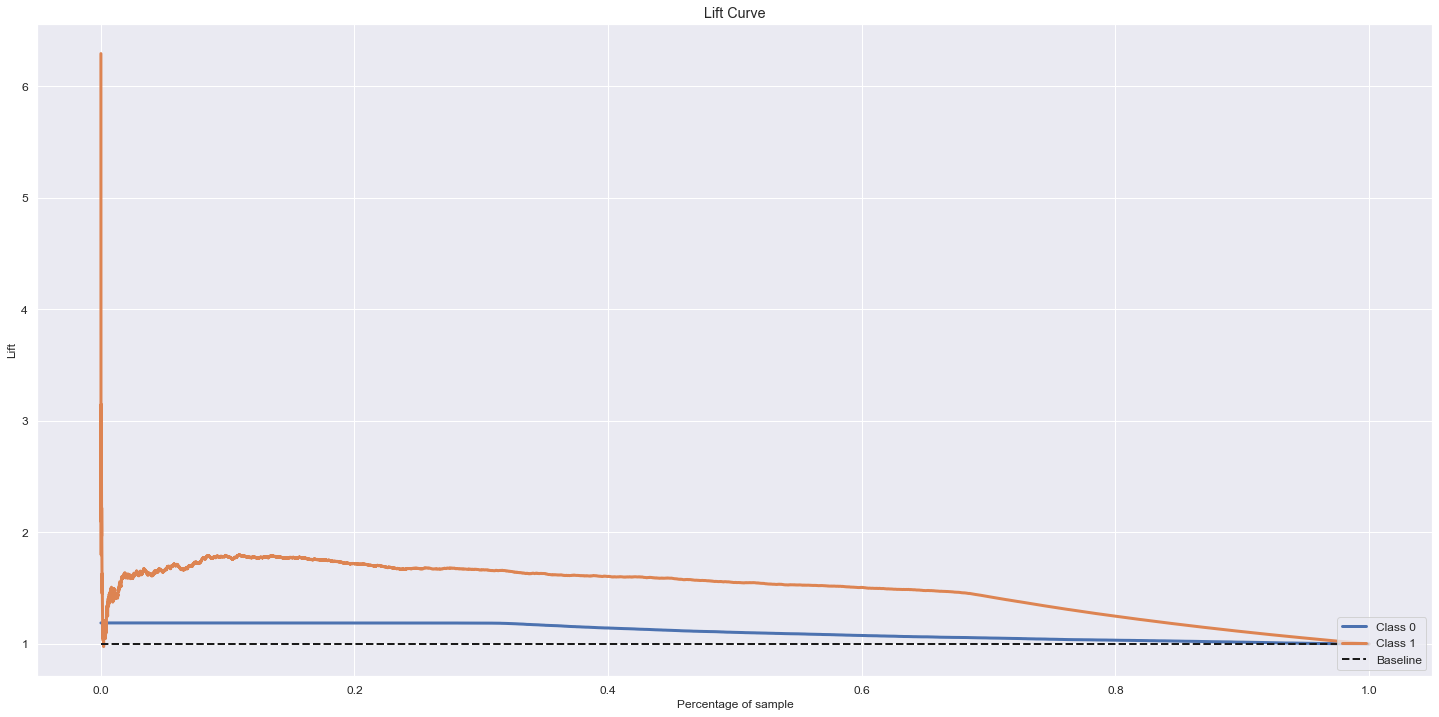

In [80]:
# Acumulative Gain
skplt.metrics.plot_lift_curve( y_val, yhat_et );

## 7.4 Random Forest

In [83]:
# Model Definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
rf.fit(x_train, y_train)

# model predict
yhat_rf = et.predict_proba( x_val )


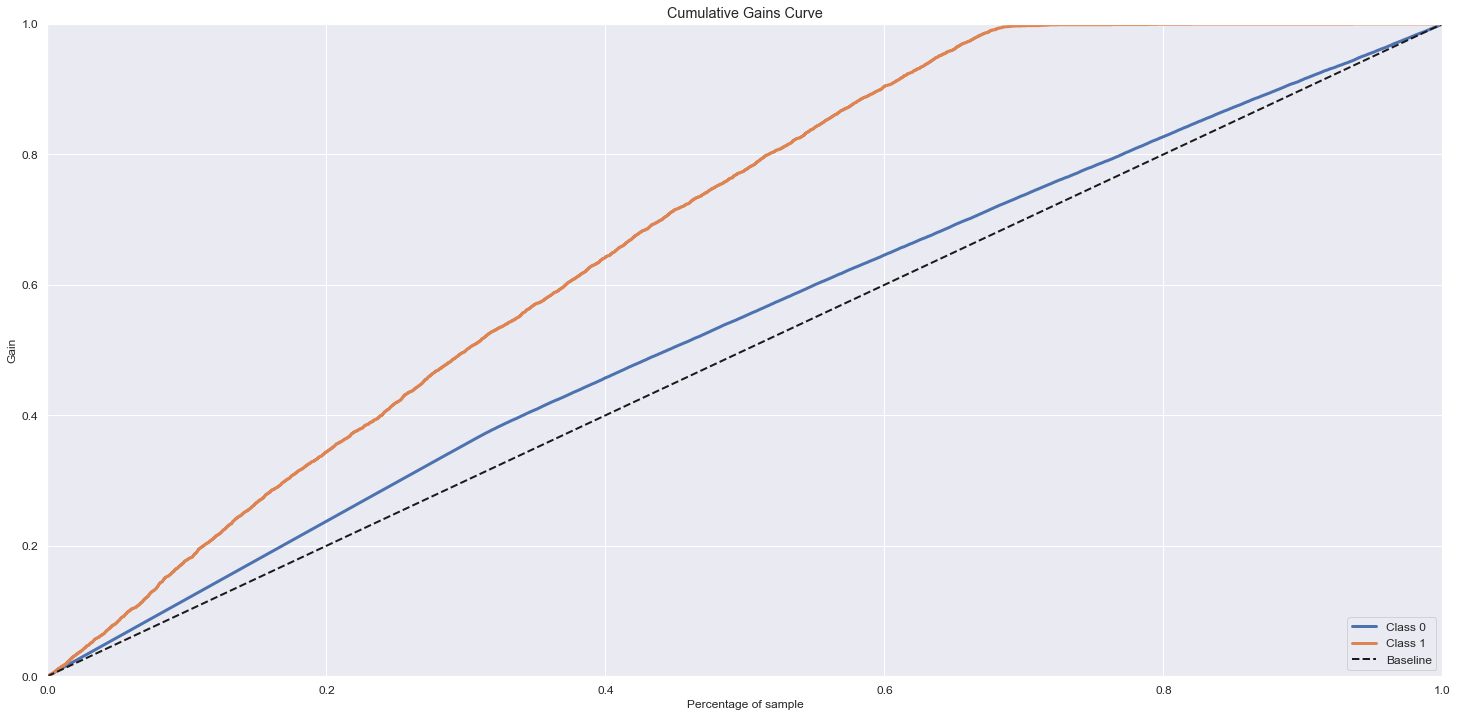

In [84]:
# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

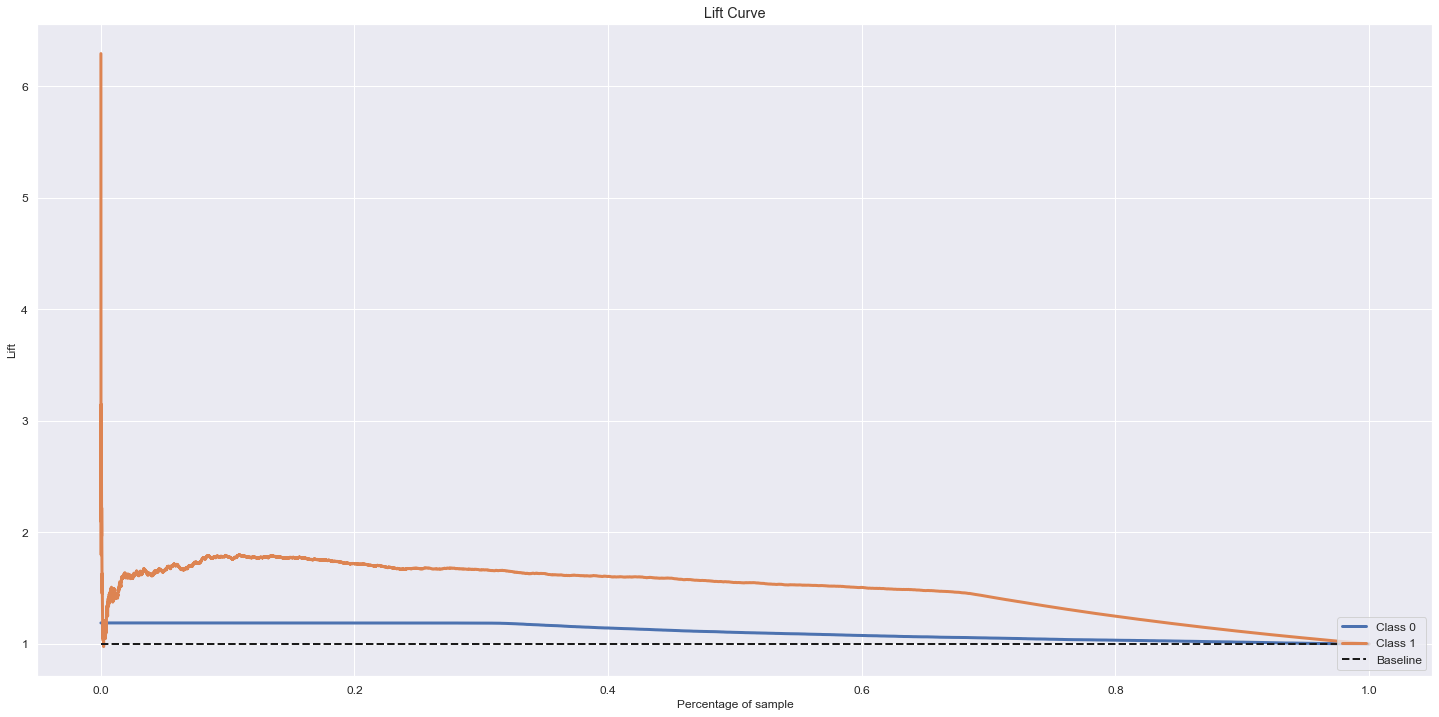

In [85]:
# Acumulative Gain
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

# 8.0 Model Performance

In [68]:
def precision_at_k( data, k=2000 ):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create rankings order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k' ]

In [69]:
def recall_at_k( data, k=2000 ):
    # Reset Index
    data = data.reset_index( drop=True )

    # Create rankings order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k' ]

In [70]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sorte Clients by propensity score
df8 = df8.sort_values( 'score', ascending=False)

# Compute Precision at k
precision_at_50 = precision_at_k( df8, k=50 )
print( 'Precision at k: {}'.format( precision_at_50))
      
# Compute Precision at k
precision_at_50 = precision_at_k( df8, k=50 )
print( 'Recall at k: {}'.format( precision_at_50) )     

Precision at k: 0.29411764705882354
Recall at k: 0.29411764705882354


In [90]:
y_true = np.array([0, 1, 2, 2])
y_score = np.array([ [0.5, 0.2, 0.2],
                     [0.3, 0.4, 0.2],
                     [0.2, 0.4, 0.3],
                     [0.7, 0.2, 0.1]])

top_k_accuracy_score(y_true, y_score, k=2 )

0.75

In [91]:
y_true  = np.array( [1, 0, 1, 1, 0, 1, 0, 0] )
y_score = np.array( [])

## 8.1 Manually curve cumulative

<AxesSubplot:xlabel='base_cum_perc', ylabel='real_cum_perc'>

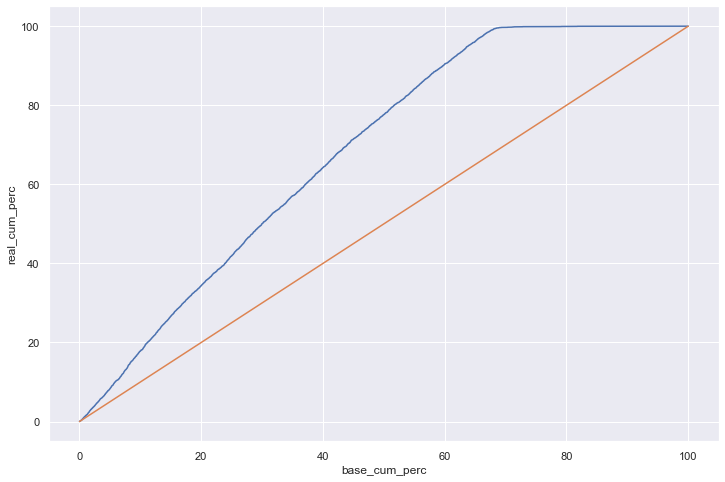

In [93]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# Ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset - Propensity Score
results['real_cum'] = results['real'].cumsum()
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base - Clients
results['base'] = range( 1, len( results ) + 1 ) 
results['base_cum_perc'] = 100*results['base']/len ( results )

# Baseline Model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12, 8) )
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results )
sns.lineplot( x='base_cum_perc', y='baseline', data=results )

## 8.2 Manually Lift Curve

<AxesSubplot:xlabel='base_cum_perc', ylabel='lift'>

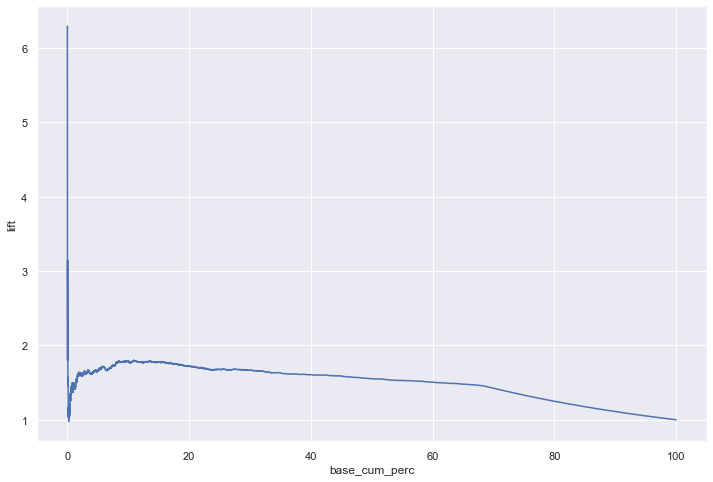

In [99]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# Ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset - Propensity Score
results['real_cum'] = results['real'].cumsum()
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base - Clients
results['base'] = range( 1, len( results ) + 1 ) 
results['base_cum_perc'] = 100*results['base']/len ( results )

# Baseline Model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12, 8) )
sns.lineplot( x='base_cum_perc', y='lift', data=results )

## 8.3 Manually ROI Curve

In [101]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# Ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset - Propensity Score
results['real_cum'] = results['real'].cumsum()
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base - Clients
results['base'] = range( 1, len( results ) + 1 ) 
results['base_cum_perc'] = 100*results['base']/len ( results )

# Baseline Model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']


# plt.figure( figsize=(12, 8) )
# sns.lineplot( x='base_cum_perc', y='lift', data=results )

In [105]:
# Compute Bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else
                                                             0.8 if ( x >= 0.80) & ( x <= 0.90) else
                                                             0.7 if ( x >= 0.70) & ( x <= 0.80) else
                                                             0.6 if ( x >= 0.60) & ( x <= 0.70) else
                                                             0.5 if ( x >= 0.50) & ( x <= 0.60) else
                                                             0.4 if ( x >= 0.40) & ( x <= 0.50) else
                                                             0.3 if ( x >= 0.30) & ( x <= 0.40) else
                                                             0.2 if ( x >= 0.20) & ( x <= 0.30) else
                                                             0.1 if ( x >= 0.10) & ( x <= 0.20) else 0.01 )


# Aggreging Clients among Buckets
df = results[['prediction', 'bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.coulumns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute Revenue and Cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score']
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# Revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )
df

/var/folders/pc/6sglrsq96ws5kp74fjj4j02h0000gn/T/ipykernel_980/391177123.py:15: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.coulumns = df.columns.droplevel()


,index,clients,propensity_score,gross_revenue,cost,base,revenue
9,0.90,3,0.909,109.08,12,0.000114,97.08
8,0.80,7,0.803,224.84,28,0.000379,196.84
7,0.70,28,0.700,784.00,112,0.001440,672.00
6,0.60,78,0.601,1875.12,312,0.004396,1563.12
5,0.50,251,0.500,5020.00,1004,0.013907,4016.00
4,0.40,640,0.400,10240.00,2560,0.038158,7680.00
3,0.30,1482,0.300,17784.00,5928,0.094316,11856.00
2,0.20,3153,0.200,25224.00,12612,0.213793,12612.00
1,0.10,6682,0.100,26728.00,26728,0.466995,0.00
0,0.01,14066,0.000,0.00,56264,1.000000,-56264.00


<AxesSubplot:xlabel='base', ylabel='revenue'>

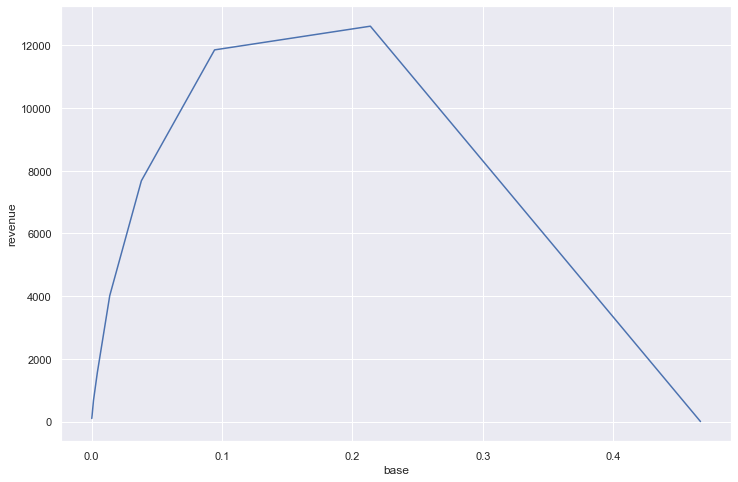

In [106]:
plt.figure( figsize=(12,8) )
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux)

# 9.0 Deploy to production

In [109]:
pickle.dump (lr_model, open( '/Users/adriele/Documents/repos/pa004/model/lr_model.pkl', 'wb') )

## 9.1 Health Insurance Class

In [244]:

import pandas as pd
import numpy as np
import pickle


class HealthInsurance():
    def __init__( self ):
        
        self.annual_premium_scaler            = pickle.load ( open( '/Users/adriele/Documents/repos/pa004/parameter/annual_premium_scaler.pkl', 'rb') )
        self.age_scaler                       = pickle.load ( open( '/Users/adriele/Documents/repos/pa004/features/age_scaler.pkl', 'rb') )
        self.vintage_scaler                   = pickle.load ( open( '/Users/adriele/Documents/repos/pa004/features/vintage_scaler.pkl', 'rb') )
        self.target_encode_region_code_scaler = pickle.load ( open( '/Users/adriele/Documents/repos/pa004/features/target_encode_region_code_scaler.pkl', 'rb') )
        self.target_encode_gender_scaler      = pickle.load ( open( '/Users/adriele/Documents/repos/pa004/features/target_encode_gender_scaler.pkl', 'rb') )
        self.fe_policy_sales_channel_scaler   = pickle.load ( open( '/Users/adriele/Documents/repos/pa004/features/fe_policy_sales_channel_scaler.pkl', 'rb') )

        
    def data_cleaning( self, df1 ): 
        
        # rename columns
        df1.columns = ['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
                       'driving_license', 'vehicle_age', 'vehicle_damage',
                       'previously_insured', 'annual_premium', 'vintage', 'response']
        
        return df1

    def feature_engeneering( self, df2 ):
        
        # Vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' 
                                                      if x == '> 2 Years' else 'betwenn_1_2_years' 
                                                      if x == '1-2 Year' else 'below_1_year')

        # Vehicle demage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'yes' else 0)
        
        return df2
    
    # =========================================================================================
    
    def data_preparation( self, df5):
        
        # Annual Premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[[ 'annual_premium']].values)
        
        # age
        df5['age'] = self.age_scaler.transform(df5[['age']].values)

        # Vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values)
        
        # Region Code
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )
        
        # gender
        df5.loc[:, 'gender'] = df5['gender'].map( self.target_encode_gender_scaler )
        
        # vehicle_age
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(  self.fe_policy_sales_channel_scaler  )
        
        
        cols_selected = ['vintage','annual_premium', 'age', 'region_code','vehicle_damage',
                         'previously_insured', 'policy_sales_channel', 'gender'] 
        
        return df5[ cols_selected]
    
    
    def get_prediction( self, model, original_data, test_data):
        
        #prediction
        pred = model.predict( test_data)
        
        # Join pred into original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )
    
        


        
        

# 9.2 API Handler

In [245]:
import pandas as pd
import numpy as np
import pickle
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

# load model

model = picle.load( open('/Users/adriele/Documents/repos/pa004/model/lr_model.pkl','rb') ) 

# initialized API    
app = Flask ( __name__ )

@app.route( '/healthinsurance/predict', methods=['POST'] )

def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json:  # there is data
        if isinstance( test_json, dict): 
            test_raw = pd.DataFrame( test_json, index=[0] )
        
        else:  # Multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        
        # Instanting HI class
        pipeline = HealthInsurance ()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3)
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__  == '__main__':
    app.run( '0.0.0.0', debug=True )

ModuleNotFoundError: No module named 'healthinsurance'

# 9..3 API Test

In [340]:
import requests


x = df4.drop( 'response', axis=1 )
y = df4['response'].copy()
x_train, x_validation, y_train, y_validation = ms.train_test_split( x, y, test_size=0.20 )

# Load Datase
df_test = x_validation
df_test['response'] = y_validation

df_test = df_test.sample(1000)
df_test.head(10)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
14233,14233,Male,54,46,26,1,betwenn_1_2_years,0,0,26535,157,0
14149,14149,Male,53,48,124,1,betwenn_1_2_years,0,1,2630,28,0
89765,89765,Male,55,1,26,1,betwenn_1_2_years,0,1,2630,30,0
80726,80726,Female,46,8,124,1,betwenn_1_2_years,0,1,2630,108,0
43130,43130,Female,47,8,124,1,over_2_years,0,0,27182,248,0
8074,8074,Male,56,46,156,1,over_2_years,0,0,2630,143,1
80500,80500,Male,51,9,124,1,betwenn_1_2_years,0,0,34498,139,0
65094,65094,Male,70,8,30,1,betwenn_1_2_years,0,0,46459,83,0
76667,76667,Male,49,48,154,1,over_2_years,0,0,2630,72,0
17064,17064,Female,54,8,156,1,betwenn_1_2_years,0,0,26204,137,0


In [344]:
df_test.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [342]:
import json
# Convert data frame to json
data = json.dumps( df_test.to_dict( orient='records') )

In [346]:
# API call
#url = 'http://0.0.0.0:5000/healthinsurance/predict'
url = 'https://pd-health-insurance.herokuapp.com/predict'
header = { 'Content-type':'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print('Status Code {}'.format( r.status_code) )


Status Code 200


In [306]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,score
0,10774,0.165886,0.225,0.185459,3,1,below_1_year,0,0,1.478523,0.017301,1,0.242973
3,53451,0.165886,0.200,0.185459,139,1,below_1_year,0,0,-0.311831,0.166090,1,0.235579
7,43985,0.148358,0.425,0.133055,11,1,below_1_year,0,0,0.190898,0.712803,0,0.140316
2,87183,0.165886,0.800,0.181493,124,1,below_1_year,0,0,0.099302,0.854671,0,0.129688
1,18796,0.148358,0.600,0.134605,124,1,below_1_year,0,0,-1.551931,0.532872,0,0.126662


In [349]:
df_test.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
14233,14233,Male,54,46,26,1,betwenn_1_2_years,0,0,26535,157,0
14149,14149,Male,53,48,124,1,betwenn_1_2_years,0,1,2630,28,0
89765,89765,Male,55,1,26,1,betwenn_1_2_years,0,1,2630,30,0
80726,80726,Female,46,8,124,1,betwenn_1_2_years,0,1,2630,108,0
43130,43130,Female,47,8,124,1,over_2_years,0,0,27182,248,0
